In [1]:
!pip install torchmetrics

In [2]:
import os
import cv2
import numpy as np
from PIL import Image
import albumentations as A
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torch.nn.functional as F


In [3]:
torch.manual_seed(42)
np.random.seed(42)

In [5]:
# with open('/kaggle/input/smartphone-image-denoising-dataset/SIDD_Small_sRGB_Only/Scene_Instances.txt') as f:
#     instances = f.read()
    
# instances = instances.split('\n')
# instances[:5]

In [4]:
with open('SIDD_Small_sRGB_Only\Scene_Instances.txt') as f:
    instances = f.read()

instances = instances.split('\n')
instances[:5]
path = 'SIDD_Small_sRGB_Only\Data\\'

noisy_images_path = []
gt_images_path = []

for f in instances:
    p = path + f + '/'
    for g in os.listdir(p):
        image_path = p + g
        
        if 'NOISY' in image_path:
            noisy_images_path.append(image_path)
        else:
            gt_images_path.append(image_path)
            

print('TOTAL NOISY IMAGES:', len(noisy_images_path))
print('TOTAL GROUND TRUTH IMAGES:', len(gt_images_path))

TOTAL NOISY IMAGES: 160
TOTAL GROUND TRUTH IMAGES: 160


In [ ]:
# path = '/kaggle/input/smartphone-image-denoising-dataset/SIDD_Small_sRGB_Only/Data/'

# noisy_images_path = []
# gt_images_path = []

# for f in instances:
#     p = path + f + '/'
#     for g in os.listdir(p):
#         image_path = p + g
        
#         if 'NOISY' in image_path:
#             noisy_images_path.append(image_path)
#         else:
#             gt_images_path.append(image_path)
            

# print('TOTAL NOISY IMAGES:', len(noisy_images_path))
# print('TOTAL GROUND TRUTH IMAGES:', len(gt_images_path))

TOTAL NOISY IMAGES: 160
TOTAL GROUND TRUTH IMAGES: 160


In [5]:
from torch.utils.data import Dataset, DataLoader, Subset

class DenoisingDataset(Dataset):
    
    def __init__(
            self, 
            noisy_images, 
            gt_images, 
            augmentation=None, 
            crop_size=256
    ):
        self.noisy_images = noisy_images
        self.gt_images = gt_images
        self.augmentation = augmentation
        self.crop_size = crop_size

        self.noisy_patches = []
        self.gt_patches = []

        for img_idx in tqdm(range(len(self.noisy_images))):
            image = cv2.cvtColor(cv2.imread(self.noisy_images[img_idx]), cv2.COLOR_BGR2RGB)
            mask = cv2.cvtColor(cv2.imread(self.gt_images[img_idx]), cv2.COLOR_BGR2RGB)
            
            h, w, _ = image.shape
            mid_h, mid_w = h // 2, w // 2
            
            patches_coords = [
                (0, 0, mid_h, mid_w),
                (0, mid_w, mid_h, w),
                (mid_h, 0, h, mid_w),
                (mid_h, mid_w, h, w)
            ]
            
            for y1, x1, y2, x2 in patches_coords:
                noisy_patch = cv2.resize(image[y1:y2, x1:x2], (crop_size, crop_size))
                gt_patch = cv2.resize(mask[y1:y2, x1:x2], (crop_size, crop_size))
                self.noisy_patches.append(noisy_patch)
                self.gt_patches.append(gt_patch)

    def __getitem__(self, idx):
        noisy_image = self.noisy_patches[idx]
        gt_image = self.gt_patches[idx]

        # Convert from HWC to CHW format
        noisy_image = torch.from_numpy(noisy_image).permute(2, 0, 1).float() / 255.0
        gt_image = torch.from_numpy(gt_image).permute(2, 0, 1).float() / 255.0
        
        return noisy_image, gt_image

    def __len__(self):
        return len(self.noisy_patches)

def get_augmentation():
    train_transform = [    
        A.OneOf(
            [
                A.HorizontalFlip(p=1),
                A.VerticalFlip(p=1),
            ],
            p=0.6667
        ),
    ]
    
    return A.Compose(train_transform)

class AugmentedDataset(Dataset):
    def __init__(self, base_dataset, augmentation, augmentations_per_image):
        self.base_dataset = base_dataset
        self.augmentation = augmentation
        self.augmentations_per_image = augmentations_per_image

    def __len__(self):
        return len(self.base_dataset) * self.augmentations_per_image

    def __getitem__(self, idx):
        base_idx = idx // self.augmentations_per_image
        augment_idx = idx % self.augmentations_per_image
        
        noisy_image, gt_image = self.base_dataset[base_idx]
        
        if augment_idx > 0:  # Apply augmentation only on additional copies
            sample = self.augmentation(image=noisy_image.permute(1, 2, 0).numpy(), mask=gt_image.permute(1, 2, 0).numpy())
            noisy_image = torch.from_numpy(sample['image']).permute(2, 0, 1).float()
            gt_image = torch.from_numpy(sample['mask']).permute(2, 0, 1).float()
        
        return noisy_image, gt_image

# Definisikan augmentasi menggunakan fungsi
train_augmentation = get_augmentation()

denoising_dataset = DenoisingDataset(
    noisy_images=noisy_images_path,
    gt_images=gt_images_path,
    crop_size=256
)

# Tentukan ukuran training, validation, dan test set
train_size = int(0.8 * len(denoising_dataset))
valid_size = int(0.1 * len(denoising_dataset))
test_size = len(denoising_dataset) - train_size - valid_size

# Membagi dataset menjadi training, validation, dan test set
train_indices, valid_indices, test_indices = random_split(range(len(denoising_dataset)), [train_size, valid_size, test_size])

# Buat subset dengan augmentasi hanya untuk dataset training
train_dataset = AugmentedDataset(Subset(denoising_dataset, train_indices), train_augmentation, augmentations_per_image=3)
valid_dataset = Subset(denoising_dataset, valid_indices)
test_dataset = Subset(denoising_dataset, test_indices)

# Membuat DataLoader untuk train, validasi, dan test dataset
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

  0%|          | 0/160 [00:00<?, ?it/s]

100%|██████████| 160/160 [02:58<00:00,  1.11s/it]


In [6]:
print(f"Size of training set: {len(train_dataset)}")
print(f"Size of validation set: {len(valid_dataset)}")
print(f"Size of test set: {len(test_dataset)}")

Size of training set: 1536
Size of validation set: 64
Size of test set: 64


In [7]:
def show_image_pairs(img, sat):
    num_images = 4
    fig, axes = plt.subplots(num_images, 2, figsize=(7, 3*num_images))
    for i in range(num_images):
        axes[i, 0].imshow(img[i].permute(1, 2, 0))
        axes[i, 0].set_title(f'Noise Image')
        axes[i, 0].axis('off')
        axes[i, 1].imshow(sat[i].permute(1, 2, 0))
        axes[i, 1].set_title(f'Ground Truth Image')
        axes[i, 1].axis('off')
    plt.tight_layout()
    plt.show()

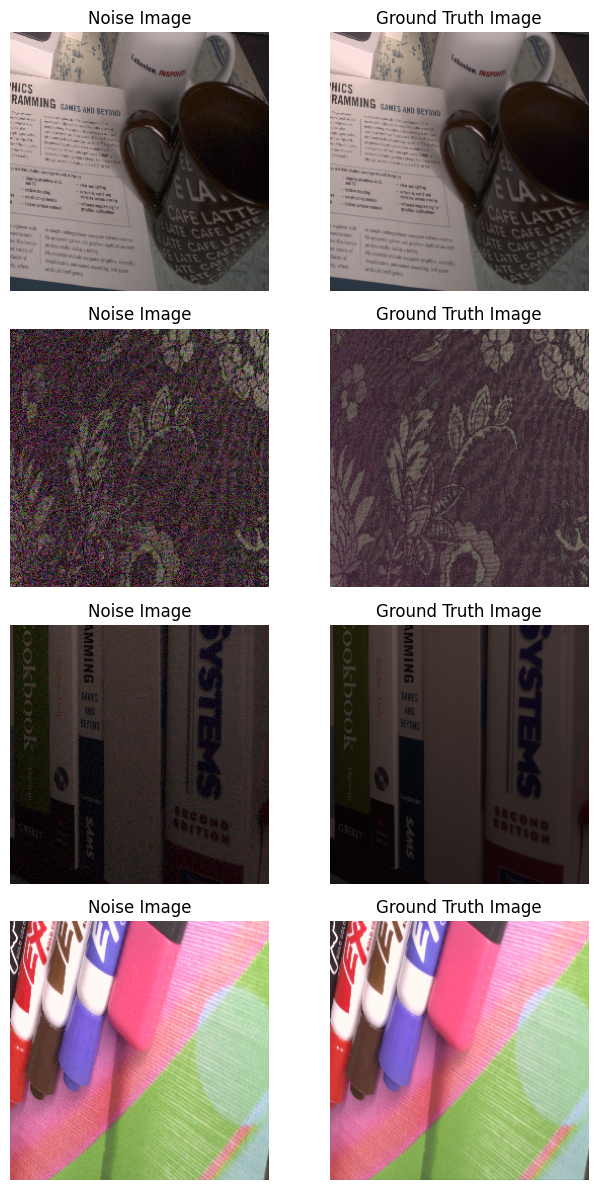

In [8]:
for sat_image, mask_image in valid_loader:
    show_image_pairs(sat_image, mask_image)
    break

In [ ]:
# FILTER = 64

In [9]:
FILTER = 32

In [10]:
class LayerNormFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, weight, bias, eps):
        ctx.eps = eps
        N, C, H, W = x.size()
        mu = x.mean(1, keepdim=True)
        var = (x - mu).pow(2).mean(1, keepdim=True)
        y = (x - mu) / (var + eps).sqrt()
        ctx.save_for_backward(y, var, weight)
        y = weight.view(1, C, 1, 1) * y + bias.view(1, C, 1, 1)
        return y

    @staticmethod
    def backward(ctx, grad_output):
        eps = ctx.eps

        N, C, H, W = grad_output.size()
        y, var, weight = ctx.saved_variables
        g = grad_output * weight.view(1, C, 1, 1)
        mean_g = g.mean(dim=1, keepdim=True)

        mean_gy = (g * y).mean(dim=1, keepdim=True)
        gx = 1. / torch.sqrt(var + eps) * (g - y * mean_gy - mean_g)
        return gx, (grad_output * y).sum(dim=3).sum(dim=2).sum(dim=0), grad_output.sum(dim=3).sum(dim=2).sum(
            dim=0), None

class LayerNorm2d(nn.Module):

    def __init__(self, channels, eps=1e-6):
        super(LayerNorm2d, self).__init__()
        self.register_parameter('weight', nn.Parameter(torch.ones(channels)))
        self.register_parameter('bias', nn.Parameter(torch.zeros(channels)))
        self.eps = eps

    def forward(self, x):
        return LayerNormFunction.apply(x, self.weight, self.bias, self.eps)
def replace_layers(model, base_size, train_size, fast_imp, **kwargs):
    for n, m in model.named_children():
        if len(list(m.children())) > 0:
            ## compound module, go inside it
            replace_layers(m, base_size, train_size, fast_imp, **kwargs)

        if isinstance(m, nn.AdaptiveAvgPool2d):
            pool = AvgPool2d(base_size=base_size, fast_imp=fast_imp, train_size=train_size)
            assert m.output_size == 1
            setattr(model, n, pool)

class Local_Base():
    def convert(self, *args, train_size, **kwargs):
        replace_layers(self, *args, train_size=train_size, **kwargs)
        imgs = torch.rand(train_size)
        with torch.no_grad():
            self.forward(imgs)

class SimpleGate(nn.Module):
    def forward(self, x):
        x1, x2 = x.chunk(2, dim=1)
        return x1 * x2

class NAFBlock(nn.Module):
    def __init__(self, c, DW_Expand=2, FFN_Expand=2, drop_out_rate=0.):
        super().__init__()
        dw_channel = c * DW_Expand
        self.conv1 = nn.Conv2d(in_channels=c, out_channels=dw_channel, kernel_size=1, padding=0, stride=1, groups=1, bias=True)
        self.conv2 = nn.Conv2d(in_channels=dw_channel, out_channels=dw_channel, kernel_size=3, padding=1, stride=1, groups=dw_channel,
                               bias=True)
        self.conv3 = nn.Conv2d(in_channels=dw_channel // 2, out_channels=c, kernel_size=1, padding=0, stride=1, groups=1, bias=True)

        # Simplified Channel Attention
        self.sca = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels=dw_channel // 2, out_channels=dw_channel // 2, kernel_size=1, padding=0, stride=1,
                      groups=1, bias=True),
        )

        # SimpleGate
        self.sg = SimpleGate()

        ffn_channel = FFN_Expand * c
        self.conv4 = nn.Conv2d(in_channels=c, out_channels=ffn_channel, kernel_size=1, padding=0, stride=1, groups=1, bias=True)
        self.conv5 = nn.Conv2d(in_channels=ffn_channel // 2, out_channels=c, kernel_size=1, padding=0, stride=1, groups=1, bias=True)

        self.norm1 = LayerNorm2d(c)
        self.norm2 = LayerNorm2d(c)

        self.dropout1 = nn.Dropout(drop_out_rate) if drop_out_rate > 0. else nn.Identity()
        self.dropout2 = nn.Dropout(drop_out_rate) if drop_out_rate > 0. else nn.Identity()

        self.beta = nn.Parameter(torch.zeros((1, c, 1, 1)), requires_grad=True)
        self.gamma = nn.Parameter(torch.zeros((1, c, 1, 1)), requires_grad=True)

    def forward(self, inp):
        x = inp

        x = self.norm1(x)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.sg(x)
        x = x * self.sca(x)
        x = self.conv3(x)

        x = self.dropout1(x)

        y = inp + x * self.beta

        x = self.conv4(self.norm2(y))
        x = self.sg(x)
        x = self.conv5(x)

        x = self.dropout2(x)

        return y + x * self.gamma

class HalfUNet(nn.Module):
    def __init__(self, input_channels=3):
        super(HalfUNet, self).__init__()
        self.initial = nn.Conv2d(3, FILTER, 1, 1)
        self.conv1 = nn.Sequential(
            NAFBlock(FILTER),
            NAFBlock(FILTER)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Sequential(
            NAFBlock(FILTER),
            NAFBlock(FILTER)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Sequential(
            NAFBlock(FILTER),
            NAFBlock(FILTER)
        )

        self.conv_up3 = nn.Conv2d(FILTER, FILTER * 16, 1, bias=False)
        self.up3 = nn.PixelShuffle(4)
        self.conv_up2 = nn.Conv2d(FILTER, FILTER * 4, 1, bias=False)
        self.up2 = nn.PixelShuffle(2)
        self.final_conv = nn.Conv2d(FILTER, 3, kernel_size=1)
        # If you want to perform multi-class segmentation, change the output channels to the desired number

    def forward(self, x):
        x = self.initial(x)
        x1 = self.conv1(x)
        pool1 = self.pool1(x1)
        x2 = self.conv2(pool1)
        pool2 = self.pool2(x2)
        x3 = self.conv3(pool2)

        up3 = self.conv_up3(x3)
        up3 = self.up3(up3)

        up2 = self.conv_up2(x2)
        up2 = self.up2(up2)
        up_scaled = x1 + up2 + up3
        output = self.final_conv(up_scaled)
        return output

# Example usage:
input_tensor = torch.randn(1, 3, 256, 256)  # Example input tensor
model = HalfUNet()
output_tensor = model(input_tensor)
print(output_tensor.shape)  # Print the shape of the output tensor

torch.Size([1, 3, 256, 256])


In [11]:
model.eval()

HalfUNet(
  (initial): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv1): Sequential(
    (0): NAFBlock(
      (conv1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
      (conv3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      (sca): Sequential(
        (0): AdaptiveAvgPool2d(output_size=1)
        (1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      )
      (sg): SimpleGate()
      (conv4): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      (conv5): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      (norm1): LayerNorm2d()
      (norm2): LayerNorm2d()
      (dropout1): Identity()
      (dropout2): Identity()
    )
    (1): NAFBlock(
      (conv1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
      (conv3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    

In [18]:
# def get_model_params(model):
#     total_params = sum(p.numel() for p in model.parameters())
#     trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
#     return total_params, trainable_params


# # Calculate and print model parameters
# total_params, trainable_params = get_model_params(model)
# print(f"Total parameters: {total_params}")
# print(f"Trainable parameters: {trainable_params}")

In [12]:
from torchmetrics.image import StructuralSimilarityIndexMeasure

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

def psnr(img1, img2, data_range=1.0):
    mse = F.mse_loss(img1, img2)
    psnr_val = 20 * torch.log10(data_range / torch.sqrt(mse))
    return psnr_val

def loss_func(x, y):
    return 100 - psnr(x, y)

In [ ]:
# pretrained_weights = torch.load('/kaggle/working/naf_128.pth', map_location=device)

# # Remove the 'module.' prefix from the keys
# new_state_dict = {}
# for k, v in pretrained_weights.items():
#     new_key = k.replace('module.', '')
#     new_state_dict[new_key] = v

# # Load the state dict into the model
# model.load_state_dict(new_state_dict)

# # Now the model is ready to use
# model.eval()

In [13]:
def evaluate_model(model, dataloader, device=device):
    model.to(device)
    model.eval()
    total_loss = 0.0
    total_psnr = 0.0
    total_ssim = 0.0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)

            loss_val = loss_func(outputs, targets)
            psnr_val = psnr(outputs, targets)
            ssim_val = ssim(outputs, targets)

            total_loss += loss_val.item()
            total_psnr += psnr_val.item()
            total_ssim += ssim_val.item()

    avg_loss = total_loss / len(dataloader)
    avg_psnr = total_psnr / len(dataloader)
    avg_ssim = total_ssim / len(dataloader)

    return avg_loss, avg_psnr, avg_ssim

In [ ]:
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [15]:
train_loss = []
train_psnr = []
train_ssim = []
val_loss = []
val_psnr = []
val_ssim = []

In [16]:
device

device(type='cpu')

In [ ]:
# model = model.to('cpu')

# # Ensure the model is not wrapped in DataParallel
# if isinstance(model, torch.nn.DataParallel):
#     model = model.module

# model.eval()

# # Iterate over a few batches from the test dataset
# for batch_idx, (lr, hr) in enumerate(test_loader):
#     # Move inputs to CPU
#     imgs_lr = lr.cpu()
#     imgs_hr = hr.cpu()

#     # Forward pass: Generate high-resolution images
#     with torch.no_grad():
#         gen_hr = model(imgs_lr)

#     # Visualize a few sample images
#     num_samples = min(5, len(imgs_lr))  # Reduced number of samples for visualization

#     fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 4))
#     for i in range(num_samples):
#         # Original LR image
#         axes[i, 0].imshow(imgs_lr[i].permute(1, 2, 0).numpy())
#         axes[i, 0].set_title("Noise")
#         axes[i, 0].axis("off")

#         # Ground truth HR image
#         axes[i, 1].imshow(imgs_hr[i].permute(1, 2, 0).numpy())
#         axes[i, 1].set_title("Ground Truth")
#         axes[i, 1].axis("off")

#         # Generated HR image
#         axes[i, 2].imshow(gen_hr[i].permute(1, 2, 0).numpy())
#         axes[i, 2].set_title("Generated")
#         axes[i, 2].axis("off")

#     plt.tight_layout()
#     plt.show()

#     # Explicitly delete variables to free memory
#     del imgs_lr, imgs_hr, gen_hr

#     # Only visualize a few batches
#     if batch_idx == 1:
#         break

In [17]:
evaluate_model(model, test_loader, device)

(92.60613059997559, 7.393869519233704, -0.029732128605246544)

In [18]:
model1 = model

In [ ]:
# import torch

# if torch.cuda.is_available():
#     device = torch.device("cuda")
#     print(f"Using device: {device}")
# else:
#     device = torch.device("cpu")
#     print(f"CUDA is not available. Using device: {device}")

In [21]:
import os
import cv2
import numpy as np
from PIL import Image
import albumentations as A
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torch.nn.functional as F

torch.manual_seed(42)
np.random.seed(42)
with open('SIDD_Small_sRGB_Only\Scene_Instances.txt') as f:
    instances = f.read()

instances = instances.split('\n')
instances[:5]
path = 'SIDD_Small_sRGB_Only\Data\\'

noisy_images_path = []
gt_images_path = []

for f in instances:
    p = path + f + '/'
    for g in os.listdir(p):
        image_path = p + g
        
        if 'NOISY' in image_path:
            noisy_images_path.append(image_path)
        else:
            gt_images_path.append(image_path)
            

print('TOTAL NOISY IMAGES:', len(noisy_images_path))
print('TOTAL GROUND TRUTH IMAGES:', len(gt_images_path))
from torch.utils.data import Dataset, DataLoader, Subset

class DenoisingDataset(Dataset):
    
    def __init__(
            self, 
            noisy_images, 
            gt_images, 
            augmentation=None, 
            crop_size=256
    ):
        self.noisy_images = noisy_images
        self.gt_images = gt_images
        self.augmentation = augmentation
        self.crop_size = crop_size

        self.noisy_patches = []
        self.gt_patches = []

        for img_idx in tqdm(range(len(self.noisy_images))):
            image = cv2.cvtColor(cv2.imread(self.noisy_images[img_idx]), cv2.COLOR_BGR2RGB)
            mask = cv2.cvtColor(cv2.imread(self.gt_images[img_idx]), cv2.COLOR_BGR2RGB)
            
            h, w, _ = image.shape
            mid_h, mid_w = h // 2, w // 2
            
            patches_coords = [
                (0, 0, mid_h, mid_w),
                (0, mid_w, mid_h, w),
                (mid_h, 0, h, mid_w),
                (mid_h, mid_w, h, w)
            ]
            
            for y1, x1, y2, x2 in patches_coords:
                noisy_patch = cv2.resize(image[y1:y2, x1:x2], (crop_size, crop_size))
                gt_patch = cv2.resize(mask[y1:y2, x1:x2], (crop_size, crop_size))
                self.noisy_patches.append(noisy_patch)
                self.gt_patches.append(gt_patch)

    def __getitem__(self, idx):
        noisy_image = self.noisy_patches[idx]
        gt_image = self.gt_patches[idx]

        # Convert from HWC to CHW format
        noisy_image = torch.from_numpy(noisy_image).permute(2, 0, 1).float() / 255.0
        gt_image = torch.from_numpy(gt_image).permute(2, 0, 1).float() / 255.0
        
        return noisy_image, gt_image

    def __len__(self):
        return len(self.noisy_patches)

def get_augmentation():
    train_transform = [    
        A.OneOf(
            [
                A.HorizontalFlip(p=1),
                A.VerticalFlip(p=1),
            ],
            p=0.6667
        ),
    ]
    
    return A.Compose(train_transform)

class AugmentedDataset(Dataset):
    def __init__(self, base_dataset, augmentation, augmentations_per_image):
        self.base_dataset = base_dataset
        self.augmentation = augmentation
        self.augmentations_per_image = augmentations_per_image

    def __len__(self):
        return len(self.base_dataset) * self.augmentations_per_image

    def __getitem__(self, idx):
        base_idx = idx // self.augmentations_per_image
        augment_idx = idx % self.augmentations_per_image
        
        noisy_image, gt_image = self.base_dataset[base_idx]
        
        if augment_idx > 0:  # Apply augmentation only on additional copies
            sample = self.augmentation(image=noisy_image.permute(1, 2, 0).numpy(), mask=gt_image.permute(1, 2, 0).numpy())
            noisy_image = torch.from_numpy(sample['image']).permute(2, 0, 1).float()
            gt_image = torch.from_numpy(sample['mask']).permute(2, 0, 1).float()
        
        return noisy_image, gt_image

# Definisikan augmentasi menggunakan fungsi
train_augmentation = get_augmentation()

denoising_dataset = DenoisingDataset(
    noisy_images=noisy_images_path,
    gt_images=gt_images_path,
    crop_size=256
)

# Tentukan ukuran training, validation, dan test set
train_size = int(0.8 * len(denoising_dataset))
valid_size = int(0.1 * len(denoising_dataset))
test_size = len(denoising_dataset) - train_size - valid_size

# Membagi dataset menjadi training, validation, dan test set
train_indices, valid_indices, test_indices = random_split(range(len(denoising_dataset)), [train_size, valid_size, test_size])

# Buat subset dengan augmentasi hanya untuk dataset training
train_dataset = AugmentedDataset(Subset(denoising_dataset, train_indices), train_augmentation, augmentations_per_image=3)
valid_dataset = Subset(denoising_dataset, valid_indices)
test_dataset = Subset(denoising_dataset, test_indices)

# Membuat DataLoader untuk train, validasi, dan test dataset
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
FILTER = 128
class LayerNormFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, weight, bias, eps):
        ctx.eps = eps
        N, C, H, W = x.size()
        mu = x.mean(1, keepdim=True)
        var = (x - mu).pow(2).mean(1, keepdim=True)
        y = (x - mu) / (var + eps).sqrt()
        ctx.save_for_backward(y, var, weight)
        y = weight.view(1, C, 1, 1) * y + bias.view(1, C, 1, 1)
        return y

    @staticmethod
    def backward(ctx, grad_output):
        eps = ctx.eps

        N, C, H, W = grad_output.size()
        y, var, weight = ctx.saved_variables
        g = grad_output * weight.view(1, C, 1, 1)
        mean_g = g.mean(dim=1, keepdim=True)

        mean_gy = (g * y).mean(dim=1, keepdim=True)
        gx = 1. / torch.sqrt(var + eps) * (g - y * mean_gy - mean_g)
        return gx, (grad_output * y).sum(dim=3).sum(dim=2).sum(dim=0), grad_output.sum(dim=3).sum(dim=2).sum(
            dim=0), None

class LayerNorm2d(nn.Module):

    def __init__(self, channels, eps=1e-6):
        super(LayerNorm2d, self).__init__()
        self.register_parameter('weight', nn.Parameter(torch.ones(channels)))
        self.register_parameter('bias', nn.Parameter(torch.zeros(channels)))
        self.eps = eps

    def forward(self, x):
        return LayerNormFunction.apply(x, self.weight, self.bias, self.eps)
def replace_layers(model, base_size, train_size, fast_imp, **kwargs):
    for n, m in model.named_children():
        if len(list(m.children())) > 0:
            ## compound module, go inside it
            replace_layers(m, base_size, train_size, fast_imp, **kwargs)

        if isinstance(m, nn.AdaptiveAvgPool2d):
            pool = AvgPool2d(base_size=base_size, fast_imp=fast_imp, train_size=train_size)
            assert m.output_size == 1
            setattr(model, n, pool)

class Local_Base():
    def convert(self, *args, train_size, **kwargs):
        replace_layers(self, *args, train_size=train_size, **kwargs)
        imgs = torch.rand(train_size)
        with torch.no_grad():
            self.forward(imgs)

class SimpleGate(nn.Module):
    def forward(self, x):
        x1, x2 = x.chunk(2, dim=1)
        return x1 * x2

class NAFBlock(nn.Module):
    def __init__(self, c, DW_Expand=2, FFN_Expand=2, drop_out_rate=0.):
        super().__init__()
        dw_channel = c * DW_Expand
        self.conv1 = nn.Conv2d(in_channels=c, out_channels=dw_channel, kernel_size=1, padding=0, stride=1, groups=1, bias=True)
        self.conv2 = nn.Conv2d(in_channels=dw_channel, out_channels=dw_channel, kernel_size=3, padding=1, stride=1, groups=dw_channel,
                               bias=True)
        self.conv3 = nn.Conv2d(in_channels=dw_channel // 2, out_channels=c, kernel_size=1, padding=0, stride=1, groups=1, bias=True)

        # Simplified Channel Attention
        self.sca = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels=dw_channel // 2, out_channels=dw_channel // 2, kernel_size=1, padding=0, stride=1,
                      groups=1, bias=True),
        )

        # SimpleGate
        self.sg = SimpleGate()

        ffn_channel = FFN_Expand * c
        self.conv4 = nn.Conv2d(in_channels=c, out_channels=ffn_channel, kernel_size=1, padding=0, stride=1, groups=1, bias=True)
        self.conv5 = nn.Conv2d(in_channels=ffn_channel // 2, out_channels=c, kernel_size=1, padding=0, stride=1, groups=1, bias=True)

        self.norm1 = LayerNorm2d(c)
        self.norm2 = LayerNorm2d(c)

        self.dropout1 = nn.Dropout(drop_out_rate) if drop_out_rate > 0. else nn.Identity()
        self.dropout2 = nn.Dropout(drop_out_rate) if drop_out_rate > 0. else nn.Identity()

        self.beta = nn.Parameter(torch.zeros((1, c, 1, 1)), requires_grad=True)
        self.gamma = nn.Parameter(torch.zeros((1, c, 1, 1)), requires_grad=True)

    def forward(self, inp):
        x = inp

        x = self.norm1(x)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.sg(x)
        x = x * self.sca(x)
        x = self.conv3(x)

        x = self.dropout1(x)

        y = inp + x * self.beta

        x = self.conv4(self.norm2(y))
        x = self.sg(x)
        x = self.conv5(x)

        x = self.dropout2(x)

        return y + x * self.gamma

class HalfUNet(nn.Module):
    def __init__(self, input_channels=3):
        super(HalfUNet, self).__init__()
        self.initial = nn.Conv2d(3, FILTER, 1, 1)
        self.conv1 = nn.Sequential(
            NAFBlock(FILTER),
            NAFBlock(FILTER)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Sequential(
            NAFBlock(FILTER),
            NAFBlock(FILTER)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Sequential(
            NAFBlock(FILTER),
            NAFBlock(FILTER)
        )

        self.conv_up3 = nn.Conv2d(FILTER, FILTER * 16, 1, bias=False)
        self.up3 = nn.PixelShuffle(4)
        self.conv_up2 = nn.Conv2d(FILTER, FILTER * 4, 1, bias=False)
        self.up2 = nn.PixelShuffle(2)
        self.final_conv = nn.Conv2d(FILTER, 3, kernel_size=1)
        # If you want to perform multi-class segmentation, change the output channels to the desired number

    def forward(self, x):
        x = self.initial(x)
        x1 = self.conv1(x)
        pool1 = self.pool1(x1)
        x2 = self.conv2(pool1)
        pool2 = self.pool2(x2)
        x3 = self.conv3(pool2)

        up3 = self.conv_up3(x3)
        up3 = self.up3(up3)

        up2 = self.conv_up2(x2)
        up2 = self.up2(up2)
        up_scaled = x1 + up2 + up3
        output = self.final_conv(up_scaled)
        return output

# Example usage:
input_tensor = torch.randn(1, 3, 256, 256)  # Example input tensor
model = HalfUNet()
output_tensor = model(input_tensor)
print(output_tensor.shape)  # Print the shape of the output tensor
from torchmetrics.image import StructuralSimilarityIndexMeasure

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

def psnr(img1, img2, data_range=1.0):
    mse = F.mse_loss(img1, img2)
    psnr_val = 20 * torch.log10(data_range / torch.sqrt(mse))
    return psnr_val

def loss_func(x, y):
    return 100 - psnr(x, y)
def evaluate_model(model, dataloader, device=device):
    model.to(device)
    model.eval()
    total_loss = 0.0
    total_psnr = 0.0
    total_ssim = 0.0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)

            loss_val = loss_func(outputs, targets)
            psnr_val = psnr(outputs, targets)
            ssim_val = ssim(outputs, targets)

            total_loss += loss_val.item()
            total_psnr += psnr_val.item()
            total_ssim += ssim_val.item()

    avg_loss = total_loss / len(dataloader)
    avg_psnr = total_psnr / len(dataloader)
    avg_ssim = total_ssim / len(dataloader)

    return avg_loss, avg_psnr, avg_ssim
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

TOTAL NOISY IMAGES: 160
TOTAL GROUND TRUTH IMAGES: 160


100%|██████████| 160/160 [02:43<00:00,  1.02s/it]


torch.Size([1, 3, 256, 256])


In [23]:
# 1. Initialize the model
# ... (all your class definitions) ...
FILTER = 32
model = HalfUNet()

# 2. Load the saved checkpoint
checkpoint = torch.load('naf_32_double.pth', map_location=device)

# --- The Fix ---
# Create a new state_dict with keys that don't have the "module." prefix
new_state_dict = {}
for k, v in checkpoint.items():
    if k.startswith('module.'):
        # Remove the 'module.' prefix from the key
        new_key = k[7:] 
    else:
        new_key = k
    new_state_dict[new_key] = v

# 3. Load the corrected state dictionary into the model
model.load_state_dict(new_state_dict)

# Move the model to the specified device
model.to(device)

# Set the model to evaluation mode
model.eval()

print("Model loaded successfully after removing 'module.' prefix!")

# Example usage:
input_tensor = torch.randn(1, 3, 256, 256).to(device)
with torch.no_grad():
    output_tensor = model(input_tensor)

print(f"Output tensor shape: {output_tensor.shape}")

Model loaded successfully after removing 'module.' prefix!
Output tensor shape: torch.Size([1, 3, 256, 256])


In [24]:
model1 = model

In [25]:
import math
import random
import copy
from typing import List, Dict, Tuple, Callable, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F

# -----------------------------
# 1) Masking + FakeQuant blocks
# -----------------------------

class PruneMask(nn.Module):
    """Applies a binary out-channel mask to a Conv2d's weights at forward time (no shape change)."""
    def __init__(self, conv: nn.Conv2d, mask: Optional[torch.Tensor] = None):
        super().__init__()
        assert isinstance(conv, nn.Conv2d)
        self.conv = conv
        C_out = conv.weight.shape[0]
        if mask is None:
            mask = torch.ones(C_out, dtype=torch.float32)
        self.register_buffer("mask", mask)  # shape [C_out]
    
    def set_mask(self, mask_bool: torch.Tensor):
        # Keep mask as registered buffer (in-place copy)
        mask_t = mask_bool.float().to(self.mask.device)
        self.mask.copy_(mask_t)
    
    def forward(self, x):
        # mask shape [C_out, 1, 1, 1]
        w = self.conv.weight * self.mask.view(-1, 1, 1, 1)
        b = self.conv.bias
        return F.conv2d(
            x, w, b,
            stride=self.conv.stride, padding=self.conv.padding,
            dilation=self.conv.dilation, groups=self.conv.groups
        )

class FakeQuantWeights(nn.Module):
    """
    Symmetric fake-quantization for weights of a Conv2d with bit-width b (1..bmax).
    Applies quantization at forward time (per-layer), keeps original weights for backprop/fine-tune.
    """
    def __init__(self, conv: nn.Conv2d, b_max: int = 8):
        super().__init__()
        self.conv = conv
        self.b_max = b_max
        self.b_current = b_max  # start uncompressed
        # Optional per-layer learned step (we keep simple uniform for first test)
        self.register_buffer("eps", torch.tensor(1e-8))

    def set_bitwidth(self, b: int):
        self.b_current = int(max(1, min(self.b_max, b)))

    @torch.no_grad()
    def _calc_scale(self, w: torch.Tensor, b: int) -> float:
        # Max absolute value per-tensor scale (simple, robust). Avoid 0 by eps.
        max_abs = w.abs().max().item() if w.numel() > 0 else 0.0
        max_abs = max(max_abs, float(self.eps.item()))
        # Handle 1-bit (binary) separately: return scale = max_abs (we'll use sign*scale)
        if b <= 1:
            return max_abs
        qmax = (1 << (b - 1)) - 1  # e.g., 7 for 4-bit
        # qmax should be >= 1 here; guard anyway
        qmax = max(1, qmax)
        return max_abs / float(qmax)

    @torch.no_grad()
    def _fake_quant(self, w: torch.Tensor, b: int) -> torch.Tensor:
        # b >= 32 -> treat as float (no quant)
        if b >= 32:
            return w
        # Compute scale with safe behavior for b <= 1
        scale = self._calc_scale(w, b)
        if scale == 0:
            return torch.zeros_like(w)

        if b <= 1:
            # Binary (1-bit) symmetric quant: q in {-1, +1} scaled by max_abs (scale)
            # torch.sign yields 0 for exact zero entries -> they remain zero
            q = torch.sign(w)
            return q * scale

        # multi-bit symmetric quant case (b >= 2)
        qmax = (1 << (b - 1)) - 1
        # clamp symmetric to [-qmax, qmax]
        q = torch.clamp(torch.round(w / scale), min=-qmax, max=qmax)
        return q * scale


    def forward(self, x):
        wq = self._fake_quant(self.conv.weight, self.b_current)
        b = self.conv.bias
        return F.conv2d(
            x, wq, b,
            stride=self.conv.stride, padding=self.conv.padding,
            dilation=self.conv.dilation, groups=self.conv.groups
        )

def _resolve_conv_module(conv_module, max_depth=20):
    """
    Follow ._orig_conv or .conv links until reaching a real nn.Conv2d.
    Raises TypeError if not found.
    """
    obj = conv_module
    depth = 0
    while depth < max_depth:
        if isinstance(obj, nn.Conv2d):
            return obj
        # Prefer explicit original reference if wrapper stored it
        if hasattr(obj, "_orig_conv") and obj is not getattr(obj, "_orig_conv"):
            obj = getattr(obj, "_orig_conv")
            depth += 1
            continue
        # Otherwise try a generic .conv link (older code)
        if hasattr(obj, "conv") and obj is not getattr(obj, "conv"):
            obj = getattr(obj, "conv")
            depth += 1
            continue
        break
    raise TypeError(f"Could not resolve an underlying nn.Conv2d from object of type {type(conv_module)}")

class MaskedQuantConv(nn.Module):
    """
    Wrapper that stores the original Conv2d as `_orig_conv` and exposes a resolved
    `conv` attribute that is guaranteed to be an `nn.Conv2d`.
    """
    def __init__(self, conv: nn.Module, b_max: int = 8):
        super().__init__()
        # Keep original module for unwrapping or introspection
        self._orig_conv = conv
        # Resolve to an actual nn.Conv2d (follow wrappers if necessary)
        real_conv = _resolve_conv_module(conv)
        if not isinstance(real_conv, nn.Conv2d):
            raise TypeError("MaskedQuantConv expected an nn.Conv2d (resolved), got: %s" % type(real_conv))
        self.conv = real_conv   # this is the actual Conv2d used for weights/bias
        self.masker = PruneMask(self.conv)
        self.quant = FakeQuantWeights(self.conv, b_max=b_max)

    def set_mask(self, mask_bool: torch.Tensor):
        self.masker.set_mask(mask_bool)

    def set_bitwidth(self, b: int):
        self.quant.set_bitwidth(b)

    def forward(self, x):
        # Quantize first, then mask (equivalently mask then quantize — both end up zeroing channels)
        w = self.quant._fake_quant(self.conv.weight, self.quant.b_current)
        w = w * self.masker.mask.view(-1, 1, 1, 1)
        b = self.conv.bias
        return F.conv2d(
            x, w, b,
            stride=self.conv.stride, padding=self.conv.padding,
            dilation=self.conv.dilation, groups=self.conv.groups
        )

# -----------------------------------
# 2) Model introspection & attachment
# -----------------------------------

def find_conv2d_modules(model: nn.Module,
                        include_pointwise: bool = True) -> List[Tuple[str, nn.Conv2d]]:
    """
    Returns a list of (qualified_name, Conv2d) for prunable/quantizable layers.
    include_pointwise=False will skip 1x1 convs (optional).
    """
    targets = []
    for name, m in model.named_modules():
        if isinstance(m, nn.Conv2d):
            if not include_pointwise and (m.kernel_size == (1,1)):
                continue
            targets.append((name, m))
    return targets

def attach_wrappers(model: nn.Module,
                    b_max: int = 8,
                    layer_filter: Optional[Callable[[str, nn.Conv2d], bool]] = None
                   ) -> Dict[str, MaskedQuantConv]:
    """
    Replace selected Conv2d modules by MaskedQuantConv wrappers in-place.
    Will safely skip children already wrapped, and will unwrap previous MaskedQuantConv
    if it stores the original conv in _orig_conv.
    Returns map: qualified_name -> wrapper
    """
    # Build parent map
    name_to_parent = {}
    for full_name, module in model.named_modules():
        for cname, child in module.named_children():
            name_to_parent[f"{full_name}.{cname}".lstrip(".")] = (module, cname)

    wrappers = {}
    for name, module in list(model.named_modules()):
        # we'll rely on find_conv2d_modules() for actual targets
        pass

    # Unwrap any existing MaskedQuantConv children that keep the original conv
    for full_name, (parent, child_name) in list(name_to_parent.items()):
        child = getattr(parent, child_name)
        if isinstance(child, MaskedQuantConv) and hasattr(child, "_orig_conv"):
            # replace wrapper with original conv before re-wrapping (prevent nested)
            try:
                setattr(parent, child_name, child._orig_conv)
                # update mapping to reflect original conv now present
                name_to_parent[f"{full_name}.{child_name}".lstrip(".")] = (parent, child_name)
            except Exception:
                # ignore if we cannot unwrap (keep existing)
                pass

    # Now find conv2d modules freshly and wrap them
    for name, conv in find_conv2d_modules(model):
        if layer_filter and not layer_filter(name, conv):
            continue
        # If already wrapped (someone else replaced it with MaskedQuantConv) skip
        if isinstance(conv, MaskedQuantConv):
            continue
        parent, child_name = name_to_parent[name]
        # Double-check child attr is the conv we expect (avoid aliasing surprises)
        child_obj = getattr(parent, child_name)
        if not isinstance(child_obj, nn.Conv2d):
            # If it's not a Conv2d (maybe already replaced), skip
            continue
        wrapper = MaskedQuantConv(child_obj, b_max=b_max)
        setattr(parent, child_name, wrapper)
        wrappers[name] = wrapper
    return wrappers


# -----------------------------
# 3) QUBO coefficients (A,B,D,E,F)
# -----------------------------

@torch.no_grad()
def per_filter_l1_mean(conv_weight: torch.Tensor) -> torch.Tensor:
    """
    For Conv2d weight [C_out, C_in, k, k], return vector length C_out with mean |w| per output filter.
    """
    C_out = conv_weight.shape[0]
    w = conv_weight.detach()
    # Mean abs over [C_in, k, k]
    return w.abs().view(C_out, -1).mean(dim=1)

def build_qubo_coeffs(
    model: nn.Module,
    wrappers: Dict[str, MaskedQuantConv],
    b_max: int = 8
) -> Tuple[List[Tuple[str,int]], List[Tuple[str,int]],
           torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, int, Dict[str, int]]:
    """
    Build QUBO: 
      P vars: one binary for each output filter of each selected Conv2d (prune=1, keep=0).
      Q vars: per-layer bit-removal integer encoded in K bits (K = ceil(log2(b_max))).
    Returns:
      P_index: list of (layer_name, filter_idx)
      Q_index: list of (layer_name, bit_idx)  -- these encode "bits removed"
      A (for Lp), B (for Lq), D,E,F (for R), U_size, layer_out_channels map
    """
    device = next(model.parameters()).device

    # Index sets
    P_index: List[Tuple[str, int]] = []
    Q_index: List[Tuple[str, int]] = []

    layer_out_channels: Dict[str, int] = {}
    K = math.ceil(math.log2(b_max))  # bits to encode removal [0..b_max-1]

    # Collect per-layer stats
    per_layer_filter_means = {}
    per_layer_filter_sizes = {}
    total_model_bits = 0

    for lname, wrap in wrappers.items():
        w = wrap.conv.weight.detach()
        C_out, C_in, kh, kw = w.shape
        layer_out_channels[lname] = C_out
        per_layer_filter_means[lname] = per_filter_l1_mean(w).to(device)   # |w| mean per filter
        per_layer_filter_sizes[lname] = (C_in * kh * kw)                    # N_{n,i} are same within a layer for filters
        # model size contribution if 8-bit baseline:
        total_model_bits += (C_out * C_in * kh * kw) * b_max

        # P-index: one prune bit per output filter
        for i in range(C_out):
            P_index.append((lname, i))
        # Q-index: K bits per layer (shared across all filters of that layer)
        for k in range(K):
            Q_index.append((lname, k))

    # Prepare sizes
    NP = len(P_index)
    NQ = len(Q_index)
    N = NP + NQ

    # Coeff matrices (upper triangular storage not required here; we’ll build full for clarity)
    A = torch.zeros((NP, NP), device=device)     # pruning loss
    B = torch.zeros((NQ, NQ), device=device)     # quantization loss
    D = torch.zeros(NP, device=device)           # compression (self on P)
    E = torch.zeros(NQ, device=device)           # compression (self on Q)
    F = torch.zeros((NP, NQ), device=device)     # compression (interactions P-Q)

    # --- A: Lp = sum_n sum_i sum_j A_{n,i,j} p_{n,i} p_{n,j}
    # A_{n,i,j} = (|w_ni|_mean * |w_nj|_mean) / (N_ni * N_nj)
    # If per_filter_l1_mean returns (||w||1 / N), then outer(means, means) already equals A_block.
    p_offset = 0
    layer_p_offsets = {}
    for lname, wrap in wrappers.items():
        C_out = layer_out_channels[lname]
        means = per_layer_filter_means[lname]        # this is ||w||1 / N
        # Block is outer product of per-filter mean-abs (no extra division)
        block = torch.outer(means, means)             # shape [C_out, C_out]
        A[p_offset:p_offset+C_out, p_offset:p_offset+C_out] = block
        layer_p_offsets[lname] = (p_offset, C_out)
        p_offset += C_out


    # --- B: Lq = sum_n sum_k sum_l B_{n,k,l} q_{n,k} q_{n,l}, with B_{n,k,l} = 2^{k+l}
    # That is per-layer constant block of powers of two.
    q_offset = 0
    layer_q_offsets = {}  # map lname -> (start_idx, K)
    pow2 = torch.tensor([2**k for k in range(K)], device=device, dtype=torch.float32)
    pow2_outer = torch.outer(pow2, pow2)  # [K,K]
    for lname, wrap in wrappers.items():
        B[q_offset:q_offset+K, q_offset:q_offset+K] = pow2_outer
        layer_q_offsets[lname] = (q_offset, K)
        q_offset += K

    # --- Compression term R = sum_n sum_i D_{n,i} p_{n,i} + sum_n sum_k E_{n,k} q_{n,k} - sum_{n,i,k} F_{n,i,k} p_{n,i} q_{n,k}
    # with:
    #   D_{n,i} = N_{n,i} * b_max / S
    #   E_{n,k} = sum_i (2^k * N_{n,i}) / S  = (2^k * C_out * N_{n,i}) / S
    #   F_{n,i,k} = (2^k * N_{n,i}) / S
    S = float(total_model_bits) if total_model_bits > 0 else 1.0

    # Fill D and F per-filter
    p_idx = 0
    for lname, wrap in wrappers.items():
        C_out = layer_out_channels[lname]
        Nin = per_layer_filter_sizes[lname]
        for i in range(C_out):
            D[p_idx] = (Nin * b_max) / S
            # F rows corresponding to p_{n,i} across all K q-bits for this layer:
            q_off, _ = layer_q_offsets[lname]
            for k in range(K):
                F[p_idx, q_off + k] = ( (2**k) * Nin ) / S
            p_idx += 1

    # Fill E per-layer q-bits
    for lname, wrap in wrappers.items():
        C_out = layer_out_channels[lname]
        Nin = per_layer_filter_sizes[lname]
        q_off, _ = layer_q_offsets[lname]
        for k in range(K):
            E[q_off + k] = ( (2**k) * C_out * Nin ) / S

    P_index_list = P_index
    Q_index_list = Q_index
    U_size = N

    return P_index_list, Q_index_list, A, B, D, E, F, U_size, layer_out_channels

# -----------------------------
# 4) Hamiltonian & annealer
# -----------------------------

def build_H_terms(A, B, D, E, F, beta: float, gamma: float):
    """
    Returns a callable H(xP, xQ) that computes:
      H = p^T A p + beta * q^T B q - gamma * ( D^T p + E^T q - p^T F q )
    where p in {0,1}^{NP}, q in {0,1}^{NQ}
    """
    def H(p: torch.Tensor, q: torch.Tensor) -> float:
        # Quadratic terms
        term_p = p @ (A @ p)
        term_q = q @ (B @ q)
        # Compression terms
        comp = D @ p + E @ q - (p @ (F @ q))
        return (term_p + beta * term_q - gamma * comp).item()
    return H

def decode_q_bits_to_b_per_layer(
    Q_index: List[Tuple[str,int]],
    q_bits: torch.Tensor,
    b_max: int
) -> Dict[str, int]:
    """
    q_bits encode "bits removed" r in binary for each layer.
    b = b_max - r. Clamp to [1, b_max].
    If K==0 (no q-bits), return b_max for all layers.
    """
    # Group by layer
    by_layer: Dict[str, List[Tuple[int,int]]] = {}
    for idx, (lname, k) in enumerate(Q_index):
        by_layer.setdefault(lname, []).append((k, idx))
    b_layer = {}
    if len(by_layer) == 0:
        # No quant bits: all layers keep b_max
        # We can't infer layers here from Q_index; caller should pass wrappers if needed.
        # But at least return empty dict, caller code should default to b_max.
        return b_layer

    for lname, pairs in by_layer.items():
        pairs = sorted(pairs, key=lambda x: x[0])
        r = 0
        for k, gidx in pairs:
            bit = int(q_bits[gidx].item())
            r += (bit << k)
        b = max(1, min(b_max, b_max - r))
        b_layer[lname] = b
    return b_layer


In [26]:
import numpy as np
import torch
import time
import requests
import json
import torch
import numpy as np
import math
import time
from tqdm import tqdm
from qdeepsdk import QDeepHybridSolver
from typing import Dict, List, Tuple, Callable, Optional
            
# ---------- Your solver ----------
def run_qdeep_solver(qubo_matrix, m_budget=1000, num_reads=10000):
    token = "ci29wd9u1o"
    solver = QDeepHybridSolver()
    solver.token = token
    solver.m_budget = m_budget
    solver.num_reads = num_reads

    try:
        response = solver.solve(qubo_matrix)
        result = response['QdeepHybridSolver']
        return {'configuration': result['configuration'], 'energy': result['energy'], 'time': result['time']}
    except (ValueError, requests.RequestException) as e:
        return {'error': str(e)}

# -------------------------
# Helper: build_U_full_and_qubo
# -------------------------
def build_U_full_and_qubo(A: torch.Tensor, B: torch.Tensor, D: torch.Tensor, E: torch.Tensor, F: torch.Tensor,
                          beta: float, gamma: float) -> Tuple[torch.Tensor, Dict[Tuple[int,int], float]]:
    """
    Build symmetric U_full (N x N) from components and return (U_full, qubo_dict).
      U_full is arranged as [p (NP), q (NQ)].
    """
    device = A.device  # or choose torch.device("cpu") to keep all on CPU

    # Move everything to the same device
    A = A.to(device)
    B = B.to(device)
    D = D.to(device)
    E = E.to(device)
    F = F.to(device)
    
    NP = int(A.shape[0])
    NQ = int(B.shape[0])
    N = NP + NQ
    U = torch.zeros((N, N), dtype=torch.float32, device=device)

    # Top-left block: pruning quadratic A
    if NP > 0:
        U[:NP, :NP] = A.clone()

    # Bottom-right block: beta * B
    if NQ > 0:
        U[NP:, NP:] = beta * B.clone()

    # Top-right / bottom-left: -gamma * (-0.5 * F mirrored)
    # From H = p^T A p + beta q^T B q - gamma*(D^T p + E^T q - p^T F q)
    # The bilinear p^T F q appears with coefficient (+ gamma) in the final U when we shift signs appropriately.
    # We'll encode the linear terms by subtracting gamma*D and gamma*E from the diagonal,
    # and encode the interaction p_i q_j by (-gamma * -F_ij) -> + gamma * F_ij into off-diagonals.
    if NP > 0 and NQ > 0:
        # Place half on each symmetric side to keep U symmetric
        U[:NP, NP:] = 0.5 * gamma * F.clone()
        U[NP:, :NP] = U[:NP, NP:].T

    # Diagonal linear compression terms: subtract gamma * D and gamma * E
    if NP > 0:
        idx_p = torch.arange(NP)
        U[idx_p, idx_p] = U[idx_p, idx_p] - (gamma * D)
    if NQ > 0:
        idx_q = NP + torch.arange(NQ)
        U[idx_q, idx_q] = U[idx_q, idx_q] - (gamma * E)

    # Convert symmetric U into QUBO dict as Q[(i,i)] and Q[(i,j)] for i<j
    qubo = {}
    U_np = U.cpu().numpy()
    N = U_np.shape[0]
    for i in range(N):
        qubo[(i, i)] = float(U_np[i, i])
    for i in range(N):
        for j in range(i + 1, N):
            # For symmetric U we put Q_{i,j} = U[i,j] + U[j,i] (should be 2*U[i,j])
            qval = float(U_np[i, j] + U_np[j, i])
            qubo[(i, j)] = qval

    return U, qubo

# -------------------------
# Helper: parse qdeep solver response
# -------------------------
def _parse_qdeep_response_solution(qdeep_resp: Dict, N_expected: int) -> Optional[np.ndarray]:
    """
    Robust heuristic parser to extract a single solution vector of length N_expected
    from the response dict returned by run_qdeep_solver().
    """
    if qdeep_resp is None:
        return None
    if "error" in qdeep_resp:
        return None

    cfg = qdeep_resp.get("configuration", qdeep_resp)

    # If configuration is already a list of numbers of length N_expected:
    if isinstance(cfg, list):
        # case: flat list of ints
        if len(cfg) == N_expected and all(isinstance(x, (int, float)) for x in cfg):
            arr = np.array(cfg, dtype=np.int32)
            return _normalize_solution_array(arr)
        # case: list of solution vectors (choose first matching length)
        if len(cfg) > 0 and isinstance(cfg[0], list):
            for cand in cfg:
                if len(cand) == N_expected and all(isinstance(x, (int, float)) for x in cand):
                    return _normalize_solution_array(np.array(cand, dtype=np.int32))
        # case: list of dicts e.g. [{'solution':[...], ...}, ...]
        for item in cfg:
            if isinstance(item, dict):
                for key in ("solution", "sample", "x", "vars", "vector"):
                    if key in item and isinstance(item[key], list) and len(item[key]) == N_expected:
                        return _normalize_solution_array(np.array(item[key], dtype=np.int32))

    # If config is a dict
    if isinstance(cfg, dict):
        # common keys
        for key in ("solution", "sample", "x", "vector", "bits"):
            val = cfg.get(key, None)
            if isinstance(val, list) and len(val) == N_expected:
                return _normalize_solution_array(np.array(val, dtype=np.int32))
        # maybe "solutions" nested
        nested = cfg.get("solutions", None)
        if isinstance(nested, list):
            for item in nested:
                if isinstance(item, list) and len(item) == N_expected:
                    return _normalize_solution_array(np.array(item, dtype=np.int32))
                if isinstance(item, dict):
                    for k in ("solution", "sample", "x"):
                        v = item.get(k, None)
                        if isinstance(v, list) and len(v) == N_expected:
                            return _normalize_solution_array(np.array(v, dtype=np.int32))

    # If nothing matched, try to flatten any numeric arrays found
    def _find_numeric_list(obj):
        if isinstance(obj, list):
            if len(obj) == N_expected and all(isinstance(x, (int, float)) for x in obj):
                return obj
            for sub in obj:
                res = _find_numeric_list(sub)
                if res is not None:
                    return res
        if isinstance(obj, dict):
            for v in obj.values():
                res = _find_numeric_list(v)
                if res is not None:
                    return res
        return None

    found = _find_numeric_list(cfg)
    if found is not None:
        return _normalize_solution_array(np.array(found, dtype=np.int32))

    # Nothing found
    return None

def _normalize_solution_array(arr: np.ndarray) -> np.ndarray:
    """
    Convert solution arrays possibly in {-1,+1} or floats to {0,1} int array.
    """
    arr = arr.flatten()
    # convert floats to near ints
    arr = np.round(arr).astype(np.int32)
    # If values in {-1,1}, convert: -1 -> 1? Wait: typical mapping is {+1 => 1, -1 => 0}
    unique = set(np.unique(arr).tolist())
    if unique <= { -1, 1 }:
        arr = (arr > 0).astype(np.int32)
    # Clip to 0/1
    arr = np.clip(arr, 0, 1).astype(np.int32)
    return arr

# -------------------------
# Helper: one-epoch fine-tune (user training variables used)
# -------------------------
@torch.no_grad()
def evaluate_model_wrapper(model: torch.nn.Module, valid_loader, device) -> Tuple[float, float, float]:
    """
    Wrapper for the user's evaluate_model function name. If you already have evaluate_model(valid_loader)
    then replace or adapt this.
    Returns (val_loss, val_psnr, val_ssim) - uses evaluate_model if available, else falls back to a cheap L2.
    """
    # If user provided evaluate_model previously in scope, use it
    try:
        # user must provide evaluate_model(model, valid_loader, device) in scope; if not, we fallback
        return evaluate_model(model, valid_loader, device)
    except Exception:
        # fallback: simple L2 on first batch
        model.eval()
        for inputs, targets in valid_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            out = model(inputs)
            loss = torch.nn.functional.mse_loss(out, targets).item()
            return loss, 0.0, 0.0
        return 0.0, 0.0, 0.0

def finetune_one_epoch(model: torch.nn.Module, train_loader, optimizer, loss_func, device, max_batches: Optional[int] = None, verbose: bool = True):
    """
    Fine-tune model for one epoch using the same style as your training loop.
    - train_loader: torch.DataLoader
    - optimizer: torch optimizer already configured
    - loss_func: callable(loss)
    - device: torch.device
    - max_batches: optionally limit batches (for quick runs)
    """
    model.train()
    total_loss = 0.0
    total_psnr = 0.0
    total_ssim = 0.0
    n = 0
    loop = tqdm(enumerate(train_loader), total=len(train_loader)) if verbose else enumerate(train_loader)
    for batch_idx, (inputs, targets) in loop:
        if max_batches is not None and n >= max_batches:
            break
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = loss_func(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # optional metrics, if functions available
        psnr_val = 0.0
        ssim_val = 0.0
        try:
            psnr_val = psnr(outputs, targets).item()
            ssim_val = ssim(outputs, targets).item()
        except Exception:
            pass

        total_loss += loss.item()
        total_psnr += psnr_val
        total_ssim += ssim_val
        n += 1

        if verbose:
            loop.set_description(f'Finetune Step [{batch_idx+1}/{len(train_loader)}]')
            loop.set_postfix(loss=loss.item(), psnr=psnr_val, ssim=ssim_val)

    if n == 0:
        return 0.0, 0.0, 0.0
    return (total_loss / n), (total_psnr / n), (total_ssim / n)

def load_qubo_matrix(filepath):
    """Load QUBO matrix from a file."""
    return np.loadtxt(filepath)

def to_qubo_matrix(U_full: torch.Tensor) -> np.ndarray:
    U_full = U_full.detach().cpu().numpy().astype(np.float64)
    Nmat = U_full.shape[0]
    # zero lower triangle, keep upper
    for i in range(Nmat):
        for j in range(i):
            U_full[i, j] = 0.0
    return U_full

# -------------------------
# Final: aqc_style_prune_quantize (Qdeep-based)
# -------------------------
def aqc_style_prune_quantize(
    model: torch.nn.Module,
    run_qdeep_solver_fn: Callable[[List[List[float]] , int, int], Dict],  # your run_qdeep_solver signature
    b_max: int = 8,
    beta: float = 1.0,
    gamma: float = 1.5,
    include_pointwise: bool = True,
    seed: int = 42,
    verbose: bool = True,
    # fine-tune args (optional)
    train_loader = None,
    valid_loader = None,
    optimizer = None,
    loss_func = None,
    device = None,
    finetune_max_batches: Optional[int] = None
) -> Dict[str, object]:
    """
    Full pipeline using the Qdeep solver:
      1) wrap conv layers
      2) build qubo coefficients
      3) build U_full (N x N)
      4) call run_qdeep_solver(U_full.tolist())
      5) parse solution into p*, q*
      6) apply pruning masks and bitwidths to wrappers
      7) optional: fine-tune for 1 epoch (uses provided train_loader/optimizer/loss_func)
    Returns summary dict with applied decisions and solver metadata.
    """
    # Attach wrappers (in-place replacement)
    layer_filter = (lambda n, c: True) if include_pointwise else (lambda n, c: not (isinstance(c, nn.Conv2d) and c.kernel_size == (1,1)))
    wrappers = attach_wrappers(model, b_max=b_max, layer_filter=layer_filter)

    if verbose:
        print(f"[info] Wrapped {len(wrappers)} Conv2d layers.")

    # Build QUBO coefficients
    P_index, Q_index, A, B, D, E, F, U_size, layer_out_channels = build_qubo_coeffs(model, wrappers, b_max=b_max)
    NP, NQ = len(P_index), len(Q_index)
    N = NP + NQ
    if verbose:
        print(f"[info] QUBO sizes — NP (prune vars): {NP}, NQ (quant vars): {NQ}, total: {N}")

    # Build U_full and QUBO dict (we will send matrix U_full to Qdeep)
    U_full, qubo_dict = build_U_full_and_qubo(A, B, D, E, F, beta=beta, gamma=gamma)

    # Save to .problem format (upper triangular as in your example)
    # problem_path = f"qubo_beta{beta:.4f}_gamma{gamma:.4f}.problem"
    # with open(problem_path, "w") as f:
    #     Nmat = U_full.shape[0]
    #     for i in range(Nmat):
    #         row_vals = []
    #         for j in range(Nmat):
    #             if j < i:
    #                 row_vals.append(0.0)  # keep lower triangle zeroed
    #             else:
    #                 row_vals.append(float(U_full[i, j].item()))
    #         f.write(" ".join(f"{val:.6f}" for val in row_vals) + "\n")
    # if verbose:
    #     print(f"[info] Saved QUBO matrix to {problem_path}")

    # Send as NumPy array
    qubo_matrix = to_qubo_matrix(U_full)
    print(qubo_matrix)
    
    if verbose:
        print(f"[info] Sending QUBO matrix to Qdeep solver (shape = {qubo_matrix.shape}) ...")
    
    # Call Qdeep solver
    t0 = time.time()
    qdeep_resp = run_qdeep_solver_fn(qubo_matrix)
    # with open("/kaggle/input/solver-solution1/qdeep_response.json", "r") as f:
        # qdeep_resp = json.load(f)    
    elapsed = time.time() - t0
    if verbose:
        print(f"[info] Qdeep returned in {elapsed:.3f}s")
        print(qdeep_resp)
        
    # after calling the solver:
    with open("qdeep_response.txt", "w") as f:
        json.dump(qdeep_resp, f, indent=4)
    
    # Parse solution directly from your solver's format
    if 'configuration' not in qdeep_resp:
        raise RuntimeError(f"Qdeep solver error: {qdeep_resp}")
    
    sol_arr = np.array(qdeep_resp['configuration'], dtype=np.int8)
    if sol_arr.shape[0] != N:
        raise RuntimeError(f"Unexpected solution length {sol_arr.shape[0]}, expected {N}")

    # Now sol_arr is numpy array of 0/1 bits length N.
    p_bits = sol_arr[:NP].astype(np.int32) if NP > 0 else np.array([], dtype=np.int32)
    q_bits = sol_arr[NP:].astype(np.int32) if NQ > 0 else np.array([], dtype=np.int32)

    # Convert to tensors
    p_star = torch.from_numpy(p_bits).float()
    q_star = torch.from_numpy(q_bits).float()

    # Build masks_by_layer from p_star (paper: p==1 means prune -> mask 0)
    masks_by_layer = {}
    for idx, (lname, fi) in enumerate(P_index):
        masks_by_layer.setdefault(lname, torch.ones(layer_out_channels[lname], dtype=torch.float32))
        masks_by_layer[lname][fi] = 0.0 if int(p_star[idx].item()) == 1 else 1.0

    # Decode q bits into per-layer bitwidths
    bitwidth_by_layer = decode_q_bits_to_b_per_layer(Q_index, q_star, b_max=b_max)

    # Apply to wrappers (preserve device)
    model_device = device if device is not None else next(model.parameters()).device
    for lname, wrapper in wrappers.items():
        mask = masks_by_layer[lname].to(model_device)
        # use in-place copy to keep buffer registered
        try:
            wrapper.set_mask(mask.bool())
        except Exception:
            # fallback if wrapper implementation expects float mask
            wrapper.set_mask(mask)
        wrapper.set_bitwidth(int(bitwidth_by_layer[lname]))

    if verbose:
        total_filters = sum(v.numel() for v in masks_by_layer.values())
        total_pruned = sum(int((m == 0).sum().item()) for m in masks_by_layer.values())
        print(f"[info] Applied pruning masks: {total_pruned}/{total_filters} filters pruned "
              f"({100.0 * total_pruned / max(1, total_filters):.2f}%)")
        print(f"[info] Applied per-layer bit-widths: {bitwidth_by_layer}")

    # Optional fine-tune (one epoch)
    finetune_info = {}
    if train_loader is not None and optimizer is not None and loss_func is not None:
        if verbose:
            print("[info] Starting one-epoch fine-tuning with compressed model...")
        # ensure model and data on same device
        if device is not None:
            model.to(device)
        t_ft0 = time.time()
        avg_loss, avg_psnr, avg_ssim = finetune_one_epoch(model, train_loader, optimizer, loss_func, device or model_device, max_batches=finetune_max_batches, verbose=verbose)
        t_ft = time.time() - t_ft0
        finetune_info = {
            "finetune_loss": avg_loss,
            "finetune_psnr": avg_psnr,
            "finetune_ssim": avg_ssim,
            "finetune_time_s": t_ft
        }
        if verbose:
            print(f"[info] Fine-tune done in {t_ft:.2f}s, loss={avg_loss:.6f}, psnr={avg_psnr:.4f}, ssim={avg_ssim:.4f}")

        # optionally evaluate on validation set
        if valid_loader is not None:
            val_loss, val_psnr, val_ssim = evaluate_model_wrapper(model, valid_loader, device or model_device)
            finetune_info.update({"val_loss": val_loss, "val_psnr": val_psnr, "val_ssim": val_ssim})
            if verbose:
                print(f"[info] Post-finetune validation: loss={val_loss:.6f}, psnr={val_psnr:.4f}, ssim={val_ssim:.4f}")

    # return everything useful
    return {
        "qubo_matrix_sent_shape": (len(qubo_matrix), len(qubo_matrix)),
        "qdeep_response": qdeep_resp,
        "solution_bits": sol_arr.tolist(),
        "p_star": p_bits.tolist(),
        "q_star": q_bits.tolist(),
        "masks": {k: v.tolist() for k, v in masks_by_layer.items()},
        "bitwidths": bitwidth_by_layer,
        # "finetune_info": finetune_info
    }

In [27]:
# assume you already have:
# model, device, train_loader, valid_loader, optimizer, loss_func (like in your snippet)

res = aqc_style_prune_quantize(
    model=model,
    run_qdeep_solver_fn=run_qdeep_solver,   # your function
    b_max=8,
    beta=1,
    gamma=100,
    include_pointwise=True,
    seed=123,
    verbose=True,
    train_loader=train_loader,
    valid_loader=valid_loader,
    optimizer=optimizer,
    loss_func=loss_func,
    device=device,
    finetune_max_batches=None  # or a small number during development
)


[info] Wrapped 40 Conv2d layers.
[info] QUBO sizes — NP (prune vars): 2403, NQ (quant vars): 120, total: 2523
[[ 0.18992259  0.14904103  0.12183755 ...  0.          0.
   0.        ]
 [ 0.          0.10980226  0.0934137  ...  0.          0.
   0.        ]
 [ 0.          0.          0.07189496 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.98212582  2.
   4.        ]
 [ 0.          0.          0.         ...  0.          3.96425176
   8.        ]
 [ 0.          0.          0.         ...  0.          0.
  15.92850304]]
[info] Sending QUBO matrix to Qdeep solver (shape = (2523, 2523)) ...
[info] Qdeep returned in 42.497s
{'configuration': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

  0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Dinar\AppData\Local\Temp\ipykernel_5364\2396909101.py:175: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  y, var, weight = ctx.saved_variables
Finetune Step [96/96]: 100%|██████████| 96/96 [09:42<00:00,  6.06s/it, loss=90, psnr=10, ssim=0.19]     


[info] Fine-tune done in 582.04s, loss=89.600551, psnr=10.3994, ssim=0.1938
[info] Post-finetune validation: loss=90.530315, psnr=9.4697, ssim=0.1867


In [28]:
evaluate_model(model, test_loader, device)

(89.67761611938477, 10.322383880615234, 0.19292909651994705)

In [ ]:
# --- Hyperparameter search implementation (Algorithms 1-3) ---
import copy
import math
import time
import random
import numpy as np
import torch
from typing import Callable, Optional, Dict, Any, Tuple
from tqdm import tqdm

# Utility: compute model original bits (sum over conv weights)
def _compute_model_original_bits(model: torch.nn.Module, b_max: int) -> int:
    total = 0
    for name, m in model.named_modules():
        if isinstance(m, torch.nn.Conv2d):
            C_out, C_in, kh, kw = m.weight.shape
            total += (C_out * C_in * kh * kw) * b_max
    return int(total if total > 0 else 1)

# Utility: compute reduction ratio R given masks and bitwidths (masks: layer -> 1/0 vector, bitwidths: layer->bits)
def _compute_reduction_ratio_from_masks_bitwidths(original_model: torch.nn.Module,
                                                  masks: Dict[str, list],
                                                  bitwidths: Dict[str, int],
                                                  b_max: int) -> float:
    orig_bits = 0
    new_bits = 0
    # build mapping from module name -> conv shape in original_model
    name_to_shape = {}
    for name, m in original_model.named_modules():
        if isinstance(m, torch.nn.Conv2d):
            name_to_shape[name] = tuple(m.weight.shape)  # (C_out,C_in,kh,kw)

    for lname, mask_list in masks.items():
        # skip layers not found in original (defensive)
        if lname not in name_to_shape:
            continue
        C_out, C_in, kh, kw = name_to_shape[lname]
        orig_bits += (C_out * C_in * kh * kw) * b_max
        b = bitwidths.get(lname, b_max)
        # assume mask_list length == C_out
        for fi, mval in enumerate(mask_list):
            if int(mval) == 0:  # pruned -> zero bits
                continue
            else:
                new_bits += (C_in * kh * kw) * int(b)
    # For conv layers that were not in masks (e.g., not selected), account them as original (not changed)
    for name, shape in name_to_shape.items():
        if name not in masks:
            C_out, C_in, kh, kw = shape
            orig_bits += (C_out * C_in * kh * kw) * b_max
            new_bits += (C_out * C_in * kh * kw) * b_max

    orig_bits = float(orig_bits) if orig_bits > 0 else 1.0
    reduction = (orig_bits - float(new_bits)) / orig_bits
    return float(reduction)

# Helper: extract an "accuracy" scalar from aqc result dict
def _extract_accuracy_from_aqc_result(aqc_res: Dict[str, Any]) -> Optional[float]:
    """
    Try a few keys in the returned aqc result to derive an accuracy (higher is better).
    Order of preference:
      - finetune_info['val_psnr']
      - finetune_info['finetune_psnr']
      - finetune_info['val_acc'] / finetune_info['finetune_acc']
      - finetune_info['val_ssim'] (as tie-break)
      - negative finetune_info['val_loss'] or 'finetune_loss'
    Returns None if no metric found.
    """
    fin = aqc_res.get("finetune_info", {}) if aqc_res else {}
    for key in ("val_psnr", "finetune_psnr", "val_acc", "finetune_acc", "val_ssim", "finetune_ssim"):
        if key in fin and fin[key] is not None:
            return float(fin[key])
    # losses -> convert to "higher is better" by negation
    for key in ("val_loss", "finetune_loss"):
        if key in fin and fin[key] is not None:
            return -float(fin[key])
    # fallback: if aqc returned an evaluation metric at top-level
    for key in ("val_psnr", "val_acc", "accuracy"):
        if key in aqc_res:
            return float(aqc_res[key])
    return None

# Core: call aqc_style_prune_quantize on a fresh deepcopy of model (moved to CPU), returning (accuracy, R, full_result)
def _run_aqc_on_fresh_copy(
    model: torch.nn.Module,
    run_qdeep_solver_fn: Callable,
    beta: float,
    gamma: float,
    b_max: int,
    train_loader=None,
    valid_loader=None,
    optimizer=None,
    loss_func=None,
    device=None,
    finetune_max_batches: Optional[int] = None,
    verbose: bool = False,
    seed: int = 42
) -> Tuple[Optional[float], Optional[float], Dict[str, Any]]:
    """
    Create a CPU deepcopy of model, run aqc_style_prune_quantize on that copy,
    and compute reduction ratio R using the original model's shapes.
    Returns (accuracy, R, aqc_result).
    """
    # copy model to CPU and deepcopy to avoid in-place side effects on caller's model
    try:
        model_cpu = copy.deepcopy(model.cpu())
    except Exception as e:
        # Last resort: try serializing & deserializing state_dict into a fresh instance is not possible here.
        raise RuntimeError(f"Deepcopy of model to CPU failed: {e}. Consider providing a model constructor for fresh copies.")

    # call aqc on the copied model (aqc will attach wrappers & optionally finetune)
    aqc_res = aqc_style_prune_quantize(
        model=model_cpu,
        run_qdeep_solver_fn=run_qdeep_solver_fn,
        b_max=b_max,
        beta=beta,
        gamma=gamma,
        include_pointwise=True,
        seed=seed,
        verbose=verbose,
        train_loader=train_loader,
        valid_loader=valid_loader,
        optimizer=optimizer,
        loss_func=loss_func,
        device=device,
        finetune_max_batches=finetune_max_batches
    )

    # extract accuracy
    acc = _extract_accuracy_from_aqc_result(aqc_res)
    # compute reduction ratio R using masks and bitwidths and original model shapes
    masks = aqc_res.get("masks", {})
    bitwidths = aqc_res.get("bitwidths", {})
    R = _compute_reduction_ratio_from_masks_bitwidths(model, masks, bitwidths, b_max=b_max)

    return acc, R, aqc_res

# Algorithm 2: FINDUPPERGAMMA / FINDLOWERGAMMA
def _find_upper_gamma(
    model, run_qdeep_solver_fn, beta, gamma_init, a_th,
    b_max, train_loader, valid_loader, optimizer, loss_func,
    device, finetune_max_batches, verbose, max_iters=10, seed=42
):
    gamma = gamma_init
    for i in range(max_iters):
        acc, R, res = _run_aqc_on_fresh_copy(
            model, run_qdeep_solver_fn, beta, gamma, b_max,
            train_loader, valid_loader, optimizer, loss_func, device, finetune_max_batches, verbose, seed + i
        )
        if acc is None:
            # cannot assess; be conservative and stop
            return gamma
        if acc < a_th:
            return gamma
        gamma *= 2.0
    return gamma  # last tried

def _find_lower_gamma(
    model, run_qdeep_solver_fn, beta, gamma_init, a_th,
    b_max, train_loader, valid_loader, optimizer, loss_func,
    device, finetune_max_batches, verbose, max_iters=10, seed=42
):
    gamma = gamma_init
    for i in range(max_iters):
        acc, R, res = _run_aqc_on_fresh_copy(
            model, run_qdeep_solver_fn, beta, gamma, b_max,
            train_loader, valid_loader, optimizer, loss_func, device, finetune_max_batches, verbose, seed + i
        )
        if acc is None:
            # cannot assess; be conservative and stop
            return gamma
        if acc >= a_th:
            return gamma
        gamma /= 2.0
        if gamma <= 1e-12:
            return gamma
    return gamma

# Algorithm 3: BINSEARCHMAX (maximize gamma subject to accuracy >= a_th)
def _binsearch_max_gamma(
    model, run_qdeep_solver_fn, beta,
    gamma_l, gamma_u, a_th, b_max,
    train_loader, valid_loader, optimizer, loss_func,
    device, finetune_max_batches, verbose,
    Nbin=8, seed=1000
):
    gl = gamma_l
    gu = gamma_u
    best_gamma = gl
    for i in range(Nbin):
        gt = gl + (gu - gl) / 2.0
        acc, R, res = _run_aqc_on_fresh_copy(
            model, run_qdeep_solver_fn, beta, gt, b_max,
            train_loader, valid_loader, optimizer, loss_func, device, finetune_max_batches, verbose, seed + i
        )
        if acc is None:
            # cannot measure; break
            break
        if acc >= a_th:
            # mid is valid -> can try larger gamma
            gl = gt
            best_gamma = gt
        else:
            gu = gt
    return best_gamma

# BINSEARCHMIN (minimize beta subject to accuracy >= a_th)
def _binsearch_min_beta(
    model, run_qdeep_solver_fn, beta_low, beta_high, a_th, b_max,
    train_loader, valid_loader, optimizer, loss_func,
    device, finetune_max_batches, verbose,
    Nbin=8, seed=2000
):
    xl = beta_low
    xu = beta_high
    best_beta = xu
    for i in range(Nbin):
        xt = xl + (xu - xl) / 2.0
        acc, R, res = _run_aqc_on_fresh_copy(
            model, run_qdeep_solver_fn, xt,  # here xt used as beta, gamma to be passed appropriately below
            # to call function signature as (model, solver, beta, gamma,...), we pass xt for beta and reuse placeholder gamma
            # We'll use gamma as a small constant here (0.0) because beta search is independent in paper's approach (they alternate)
            # But to be accurate we need gamma value - the caller will pass current_gamma via closure below.
            # To avoid signature mismatch, this wrapper will not be used directly; we'll call a variant in outer function instead.
            0.0,  # gamma placeholder
            b_max, train_loader, valid_loader, optimizer, loss_func, device, finetune_max_batches, verbose, seed + i
        )
        # We cannot use this generic variant; the main HYPERPARAM loop below will call a version that passes both beta and the current gamma.

        # Placeholder logic (this function not used directly in final code)
        break

    return best_beta

# --- Main HYPERPARAMETER SEARCH (Algorithm 1) ---
def hyperparameter_search(
    model: torch.nn.Module,
    run_qdeep_solver_fn: Callable,
    b_max: int = 8,
    a_th: float = 30.0,              # accuracy threshold (e.g., PSNR). Set appropriately.
    Niter: int = 6,                 # number of outer iterations
    Nbin: int = 6,                  # number of binary-search steps
    seed: int = 42,
    verbose: bool = True,
    # fine-tune args forwarded to aqc
    train_loader = None,
    valid_loader = None,
    optimizer = None,
    loss_func = None,
    device = None,
    finetune_max_batches: Optional[int] = None
) -> Dict[str, Any]:
    """
    Perform the iterative search over beta and gamma following Algorithm 1.
    Returns dict with best beta/gamma and the associated aqc result.
    """

    # 1) Get initial beta as ||A||_1 / ||B||_1
    # We'll construct A and B from a single fresh copy to estimate norms.
    model_for_AB = copy.deepcopy(model.cpu())
    wrappers_tmp = attach_wrappers(model_for_AB, b_max=b_max, layer_filter=(lambda n, c: True))
    _, _, A_init, B_init, _, _, _, _, _ = build_qubo_coeffs(model_for_AB, wrappers_tmp, b_max=b_max)
    A_norm = float(A_init.abs().sum().item())
    B_norm = float(B_init.abs().sum().item())
    beta = (A_norm / max(1e-12, B_norm)) if B_norm > 0 else 1.0
    # initial gamma random small positive
    random.seed(seed)
    gamma = float(random.random() * 10000)

    if verbose:
        print(f"[hp] Init beta={beta:.6g} (A_norm={A_norm:.6g}, B_norm={B_norm:.6g}), gamma={gamma:.6g}")

    # Evaluate initial solution
    acc, R, res = _run_aqc_on_fresh_copy(model, run_qdeep_solver_fn, beta, gamma, b_max,
                                        train_loader, valid_loader, optimizer, loss_func, device,
                                        finetune_max_batches, verbose, seed=seed)
    if verbose:
        print(f"[hp] Initial eval -> acc={acc}, R={R}")

    R_best = R if R is not None else -1.0
    beta_best = beta
    gamma_best = gamma
    res_best = res

    # Outer iterative loop
    for it in range(Niter):
        if verbose:
            print(f"[hp] === Iter {it+1}/{Niter} (beta={beta:.6g}, gamma={gamma:.6g}) ===")

        # 1. Determine gamma search interval [gamma_l, gamma_u]
        if acc is None:
            # if we couldn't measure accuracy, try small gamma
            gamma_l = gamma / 2.0
            gamma_u = gamma * 2.0
        elif acc >= a_th:
            # find upper gamma where solution becomes invalid (acc < a_th)
            gamma_l = gamma
            gamma_u = _find_upper_gamma(model, run_qdeep_solver_fn, beta, gamma, a_th, b_max,
                                        train_loader, valid_loader, optimizer, loss_func, device, finetune_max_batches, verbose, seed=seed+10)
        else:
            # acc < threshold -> find a lower gamma that yields valid solution
            gamma_l = _find_lower_gamma(model, run_qdeep_solver_fn, beta, gamma, a_th, b_max,
                                        train_loader, valid_loader, optimizer, loss_func, device, finetune_max_batches, verbose, seed=seed+20)
            gamma_u = gamma

        if verbose:
            print(f"[hp] gamma interval = [{gamma_l:.6g}, {gamma_u:.6g}]")

        # 2. Binary search for maximal gamma in [gamma_l, gamma_u] s.t. acc >= a_th
        gamma_candidate = _binsearch_max_gamma(model, run_qdeep_solver_fn, beta, gamma_l, gamma_u, a_th, b_max,
                                               train_loader, valid_loader, optimizer, loss_func, device, finetune_max_batches, verbose, Nbin=Nbin, seed=seed+30)
        gamma = gamma_candidate
        if verbose:
            print(f"[hp] Found gamma={gamma:.6g}")

        # 3. Binary search to minimize beta in range [0, 2*beta] while keeping acc >= a_th
        # We must pass current gamma into the inner evaluation.
        def _run_eval_with_beta(b_try, seed_local):
            # wrapper that runs aqc with (beta=b_try, gamma=current gamma)
            return _run_aqc_on_fresh_copy(model, run_qdeep_solver_fn, b_try, gamma, b_max,
                                          train_loader, valid_loader, optimizer, loss_func, device, finetune_max_batches, verbose, seed_local)

        # binary search for minimal beta
        low_b = 0.0
        high_b = max(1e-6, 2.0 * beta)
        beta_candidate = high_b
        for bi in range(Nbin):
            mid = low_b + 0.5 * (high_b - low_b)
            mid_seed = seed + 100 + bi
            acc_mid, R_mid, res_mid = _run_eval_with_beta(mid, mid_seed)
            if acc_mid is None:
                # if cannot evaluate, move conservatively
                break
            if acc_mid >= a_th:
                # mid is valid -> can try smaller beta
                beta_candidate = mid
                high_b = mid
            else:
                low_b = mid
        beta = beta_candidate
        if verbose:
            print(f"[hp] Found beta={beta:.6g}")

        # 4. Evaluate solution at (beta,gamma) and checkpoint if R improved
        acc, R, res = _run_aqc_on_fresh_copy(model, run_qdeep_solver_fn, beta, gamma, b_max,
                                            train_loader, valid_loader, optimizer, loss_func, device, finetune_max_batches, verbose, seed + 500 + it)
        if verbose:
            print(f"[hp] Iter {it+1} eval -> acc={acc}, R={R}")

        if R is not None and R > R_best:
            R_best = R
            beta_best = beta
            gamma_best = gamma
            res_best = res
            if verbose:
                print(f"[hp] New best R={R_best:.6f} at beta={beta_best:.6g}, gamma={gamma_best:.6g}")

    # return best found
    return {
        "beta_best": beta_best,
        "gamma_best": gamma_best,
        "R_best": R_best,
        "aqc_result_best": res_best
    }

In [33]:
# model, device, train_loader, valid_loader, optimizer, loss_func must be defined as in your training script

hp_res = hyperparameter_search(
    model=model,
    run_qdeep_solver_fn=run_qdeep_solver,
    b_max=8,
    a_th=30.0,             # example: require PSNR >= 30dB after finetune
    Niter=4,               # start small for debugging
    Nbin=4,
    seed=42,
    verbose=True,
    train_loader=train_loader,
    valid_loader=valid_loader,
    optimizer=optimizer,
    loss_func=loss_func,
    device=device,
    finetune_max_batches=200   # speed up debugging; set None for full epoch
)
print("HP search results:", hp_res)

[hp] Init beta=2.11322 (A_norm=4141.9, B_norm=1960), gamma=0.739427
[info] Wrapped 40 Conv2d layers.
[info] QUBO sizes — NP (prune vars): 2403, NQ (quant vars): 120, total: 2523
[[ 0.1943581   0.14904103  0.12183755 ...  0.          0.
   0.        ]
 [ 0.          0.11423776  0.0934137  ...  0.          0.
   0.        ]
 [ 0.          0.          0.07633046 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  2.11308432  4.2264328
   8.4528656 ]
 [ 0.          0.          0.         ...  0.          8.45260143
  16.9057312 ]
 [ 0.          0.          0.         ...  0.          0.
  33.81093216]]
[info] Sending QUBO matrix to Qdeep solver (shape = (2523, 2523)) ...
[info] Qdeep returned in 60.694s
{'configuration': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

  0%|          | 0/96 [00:00<?, ?it/s]C:\Users\osama\AppData\Local\Temp\ipykernel_47388\1517665631.py:175: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  y, var, weight = ctx.saved_variables
Finetune Step [96/96]: 100%|██████████| 96/96 [06:02<00:00,  3.77s/it, loss=63.7, psnr=36.3, ssim=0.914]


[info] Fine-tune done in 362.06s, loss=63.905199, psnr=36.0948, ssim=0.9145
[info] Post-finetune validation: loss=64.951662, psnr=35.0483, ssim=0.9064
[hp] Initial eval -> acc=None, R=0.0
[hp] === Iter 1/4 (beta=2.11322, gamma=0.739427) ===
[hp] gamma interval = [0.369713, 1.47885]
[info] Wrapped 40 Conv2d layers.
[info] QUBO sizes — NP (prune vars): 2403, NQ (quant vars): 120, total: 2523
[[ 0.19434983  0.14904103  0.12183755 ...  0.          0.
   0.        ]
 [ 0.          0.1142295   0.0934137  ...  0.          0.
   0.        ]
 [ 0.          0.          0.07632221 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  2.11305118  4.2264328
   8.4528656 ]
 [ 0.          0.          0.         ...  0.          8.45253563
  16.9057312 ]
 [ 0.          0.          0.         ...  0.          0.
  33.81080246]]
[info] Sending QUBO matrix to Qdeep solver (shape = (2523, 2523)) ...
[info] Qdeep returned in 61.721s
{'configuration': [0, 0, 0, 0, 0, 0, 0, 0, 0,

Finetune Step [96/96]: 100%|██████████| 96/96 [05:23<00:00,  3.37s/it, loss=62.5, psnr=37.5, ssim=0.935]


[info] Fine-tune done in 323.87s, loss=63.916679, psnr=36.0833, ssim=0.9145
[info] Post-finetune validation: loss=64.951662, psnr=35.0483, ssim=0.9064
[hp] Found gamma=0.369713
[info] Wrapped 40 Conv2d layers.
[info] QUBO sizes — NP (prune vars): 2403, NQ (quant vars): 120, total: 2523
[[ 0.19437461  0.14904103  0.12183755 ...  0.          0.
   0.        ]
 [ 0.          0.11425428  0.0934137  ...  0.          0.
   0.        ]
 [ 0.          0.          0.07634699 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  2.11315036  4.2264328
   8.4528656 ]
 [ 0.          0.          0.         ...  0.          8.45273304
  16.9057312 ]
 [ 0.          0.          0.         ...  0.          0.
  33.81119919]]
[info] Sending QUBO matrix to Qdeep solver (shape = (2523, 2523)) ...
[info] Qdeep returned in 53.512s
{'configuration': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Finetune Step [96/96]: 100%|██████████| 96/96 [37:22<00:00, 23.36s/it, loss=64.2, psnr=35.8, ssim=0.9]     


[info] Fine-tune done in 2242.28s, loss=63.901607, psnr=36.0984, ssim=0.9145
[info] Post-finetune validation: loss=64.951662, psnr=35.0483, ssim=0.9064
[hp] Found beta=4.22643
[info] Wrapped 40 Conv2d layers.
[info] QUBO sizes — NP (prune vars): 2403, NQ (quant vars): 120, total: 2523
[[ 0.19437461  0.14904103  0.12183755 ...  0.          0.
   0.        ]
 [ 0.          0.11425428  0.0934137  ...  0.          0.
   0.        ]
 [ 0.          0.          0.07634699 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  4.22636652  8.4528656
  16.9057312 ]
 [ 0.          0.          0.         ...  0.         16.90559959
  33.8114624 ]
 [ 0.          0.          0.         ...  0.          0.
  67.62265778]]
[info] Sending QUBO matrix to Qdeep solver (shape = (2523, 2523)) ...
[info] Qdeep returned in 63.124s
{'configuration': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Finetune Step [96/96]: 100%|██████████| 96/96 [05:21<00:00,  3.35s/it, loss=62.8, psnr=37.2, ssim=0.927]


[info] Fine-tune done in 321.17s, loss=63.891900, psnr=36.1081, ssim=0.9146
[info] Post-finetune validation: loss=64.951662, psnr=35.0483, ssim=0.9064
[hp] Iter 1 eval -> acc=None, R=0.0
[hp] === Iter 2/4 (beta=4.22643, gamma=0.369713) ===
[hp] gamma interval = [0.184857, 0.739427]
[info] Wrapped 40 Conv2d layers.
[info] QUBO sizes — NP (prune vars): 2403, NQ (quant vars): 120, total: 2523
[[ 0.19437048  0.14904103  0.12183755 ...  0.          0.
   0.        ]
 [ 0.          0.11425015  0.0934137  ...  0.          0.
   0.        ]
 [ 0.          0.          0.07634285 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  4.22635031  8.4528656
  16.9057312 ]
 [ 0.          0.          0.         ...  0.         16.90556526
  33.8114624 ]
 [ 0.          0.          0.         ...  0.          0.
  67.62259674]]
[info] Sending QUBO matrix to Qdeep solver (shape = (2523, 2523)) ...
[info] Qdeep returned in 49.023s
{'configuration': [0, 0, 0, 0, 0, 0, 0, 0, 0,

Finetune Step [96/96]: 100%|██████████| 96/96 [05:41<00:00,  3.56s/it, loss=63.1, psnr=36.9, ssim=0.928]


[info] Fine-tune done in 341.86s, loss=63.871788, psnr=36.1282, ssim=0.9145
[info] Post-finetune validation: loss=64.951662, psnr=35.0483, ssim=0.9064
[hp] Found gamma=0.184857
[info] Wrapped 40 Conv2d layers.
[info] QUBO sizes — NP (prune vars): 2403, NQ (quant vars): 120, total: 2523
[[ 0.19438288  0.14904103  0.12183755 ...  0.          0.
   0.        ]
 [ 0.          0.11426254  0.0934137  ...  0.          0.
   0.        ]
 [ 0.          0.          0.07635524 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  4.2263999   8.4528656
  16.9057312 ]
 [ 0.          0.          0.         ...  0.         16.90566444
  33.8114624 ]
 [ 0.          0.          0.         ...  0.          0.
  67.6227951 ]]
[info] Sending QUBO matrix to Qdeep solver (shape = (2523, 2523)) ...
[info] Qdeep returned in 64.600s
{'configuration': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Finetune Step [96/96]: 100%|██████████| 96/96 [05:58<00:00,  3.73s/it, loss=63.6, psnr=36.4, ssim=0.918]


[info] Fine-tune done in 358.04s, loss=63.900815, psnr=36.0992, ssim=0.9145
[info] Post-finetune validation: loss=64.951662, psnr=35.0483, ssim=0.9064
[hp] Found beta=8.45287
[info] Wrapped 40 Conv2d layers.
[info] QUBO sizes — NP (prune vars): 2403, NQ (quant vars): 120, total: 2523
[[1.94382876e-01 1.49041027e-01 1.21837549e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.14262536e-01 9.34136957e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 7.63552412e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 8.45283222e+00
  1.69057312e+01 3.38114624e+01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  3.38113976e+01 6.76229248e+01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.35245712e+02]]
[info] Sending QUBO matrix to Qdeep solver (shape = (2523, 2523)) ...
[info] Qdeep returned in 52.603s
{'configurat

Finetune Step [96/96]: 100%|██████████| 96/96 [05:58<00:00,  3.73s/it, loss=62.9, psnr=37.1, ssim=0.922]


[info] Fine-tune done in 358.10s, loss=63.888538, psnr=36.1115, ssim=0.9146
[info] Post-finetune validation: loss=64.951662, psnr=35.0483, ssim=0.9064
[hp] Iter 2 eval -> acc=None, R=0.0
[hp] === Iter 3/4 (beta=8.45287, gamma=0.184857) ===
[hp] gamma interval = [0.0924283, 0.369713]
[info] Wrapped 40 Conv2d layers.
[info] QUBO sizes — NP (prune vars): 2403, NQ (quant vars): 120, total: 2523
[[1.94380805e-01 1.49041027e-01 1.21837549e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.14260472e-01 9.34136957e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 7.63531774e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 8.45282459e+00
  1.69057312e+01 3.38114624e+01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  3.38113785e+01 6.76229248e+01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.35245682e+02]]
[info]

Finetune Step [96/96]: 100%|██████████| 96/96 [05:47<00:00,  3.62s/it, loss=64.5, psnr=35.5, ssim=0.927]


[info] Fine-tune done in 347.85s, loss=63.902644, psnr=36.0974, ssim=0.9145
[info] Post-finetune validation: loss=64.951662, psnr=35.0483, ssim=0.9064
[hp] Found gamma=0.0924283
[info] Wrapped 40 Conv2d layers.
[info] QUBO sizes — NP (prune vars): 2403, NQ (quant vars): 120, total: 2523
[[1.94387004e-01 1.49041027e-01 1.21837549e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.14266671e-01 9.34136957e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 7.63593763e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 8.45284939e+00
  1.69057312e+01 3.38114624e+01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  3.38114281e+01 6.76229248e+01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.35245789e+02]]
[info] Sending QUBO matrix to Qdeep solver (shape = (2523, 2523)) ...
[info] Qdeep returned in 48.452s
{'configu

Finetune Step [96/96]: 100%|██████████| 96/96 [06:05<00:00,  3.80s/it, loss=63.3, psnr=36.7, ssim=0.936]


[info] Fine-tune done in 365.02s, loss=63.912719, psnr=36.0873, ssim=0.9145
[info] Post-finetune validation: loss=64.951662, psnr=35.0483, ssim=0.9064
[hp] Found beta=16.9057
[info] Wrapped 40 Conv2d layers.
[info] QUBO sizes — NP (prune vars): 2403, NQ (quant vars): 120, total: 2523
[[1.94387004e-01 1.49041027e-01 1.21837549e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.14266671e-01 9.34136957e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 7.63593763e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.69057140e+01
  3.38114624e+01 6.76229248e+01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  6.76228943e+01 1.35245850e+02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 2.70491638e+02]]
[info] Sending QUBO matrix to Qdeep solver (shape = (2523, 2523)) ...
[info] Qdeep returned in 64.783s
{'configurat

Finetune Step [96/96]: 100%|██████████| 96/96 [05:59<00:00,  3.74s/it, loss=64.1, psnr=35.9, ssim=0.917]


[info] Fine-tune done in 359.50s, loss=63.872625, psnr=36.1274, ssim=0.9145
[info] Post-finetune validation: loss=64.951662, psnr=35.0483, ssim=0.9064
[hp] Iter 3 eval -> acc=None, R=0.0
[hp] === Iter 4/4 (beta=16.9057, gamma=0.0924283) ===
[hp] gamma interval = [0.0462142, 0.184857]
[info] Wrapped 40 Conv2d layers.
[info] QUBO sizes — NP (prune vars): 2403, NQ (quant vars): 120, total: 2523
[[1.94385976e-01 1.49041027e-01 1.21837549e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.14265636e-01 9.34136957e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 7.63583407e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.69057102e+01
  3.38114624e+01 6.76229248e+01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  6.76228867e+01 1.35245850e+02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 2.70491608e+02]]
[info

Finetune Step [96/96]: 100%|██████████| 96/96 [05:56<00:00,  3.71s/it, loss=63.3, psnr=36.7, ssim=0.931]


[info] Fine-tune done in 356.47s, loss=63.921474, psnr=36.0785, ssim=0.9145
[info] Post-finetune validation: loss=64.951662, psnr=35.0483, ssim=0.9064
[hp] Found gamma=0.0462142
[info] Wrapped 40 Conv2d layers.
[info] QUBO sizes — NP (prune vars): 2403, NQ (quant vars): 120, total: 2523
[[1.94389060e-01 1.49041027e-01 1.21837549e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.14268735e-01 9.34136957e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 7.63614401e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.69057236e+01
  3.38114624e+01 6.76229248e+01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  6.76229095e+01 1.35245850e+02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 2.70491669e+02]]
[info] Sending QUBO matrix to Qdeep solver (shape = (2523, 2523)) ...
[info] Qdeep returned in 52.101s
{'configu

Finetune Step [96/96]: 100%|██████████| 96/96 [05:49<00:00,  3.64s/it, loss=65.7, psnr=34.3, ssim=0.906]


[info] Fine-tune done in 349.40s, loss=63.874094, psnr=36.1259, ssim=0.9145
[info] Post-finetune validation: loss=64.951662, psnr=35.0483, ssim=0.9064
[hp] Found beta=33.8115
[info] Wrapped 40 Conv2d layers.
[info] QUBO sizes — NP (prune vars): 2403, NQ (quant vars): 120, total: 2523
[[1.94389060e-01 1.49041027e-01 1.21837549e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.14268735e-01 9.34136957e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 7.63614401e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.38114548e+01
  6.76229248e+01 1.35245850e+02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.35245834e+02 2.70491699e+02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 5.40983337e+02]]
[info] Sending QUBO matrix to Qdeep solver (shape = (2523, 2523)) ...
[info] Qdeep returned in 53.326s
{'configurat

Finetune Step [96/96]: 100%|██████████| 96/96 [05:09<00:00,  3.22s/it, loss=64.6, psnr=35.4, ssim=0.886]


[info] Fine-tune done in 309.13s, loss=63.850957, psnr=36.1490, ssim=0.9145
[info] Post-finetune validation: loss=64.951662, psnr=35.0483, ssim=0.9064
[hp] Iter 4 eval -> acc=None, R=0.0
HP search results: {'beta_best': 2.113216477997449, 'gamma_best': 0.7394267984578837, 'R_best': 0.0, 'aqc_result_best': {'qubo_matrix_sent_shape': (2523, 2523), 'qdeep_response': {'configuration': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [1]:
import torch
import math
from typing import Dict, Tuple, List

def is_masked_quant_conv(m: torch.nn.Module) -> bool:
    return m.__class__.__name__ == "MaskedQuantConv" or hasattr(m, "masker") and hasattr(m, "quant")

@torch.no_grad()
def get_effective_conv_weight(layer: torch.nn.Module) -> torch.Tensor:
    """
    Return the effective weight tensor used at forward time for a conv-like layer:
      - If layer is MaskedQuantConv: returns quantized(weights) * mask
      - If layer is nn.Conv2d: returns layer.weight.data
    """
    if is_masked_quant_conv(layer):
        # try to use the wrapper's stored conv, quant and mask
        # works for the MaskedQuantConv implementation in your code
        try:
            conv = layer.conv
            # use the wrapper's fake-quant implementation (no grad)
            w = conv.weight.detach()
            # quant._fake_quant expects (w, b)
            b = int(layer.quant.b_current) if hasattr(layer, "quant") else getattr(layer, "b_current", None)
            if b is None:
                # fallback: assume float
                return w.clone()
            wq = layer.quant._fake_quant(w, b)
            # apply mask (masker.mask shape [C_out])
            mask = layer.masker.mask.detach().view(-1, 1, 1, 1)
            return (wq * mask).detach().cpu()
        except Exception:
            # fallback: if wrapper structure differs, try to reconstruct: mask in .mask or .masker
            try:
                w = layer._orig_conv.weight.detach().cpu()
                return w.clone()
            except Exception:
                raise
    elif isinstance(layer, torch.nn.Conv2d):
        return layer.weight.detach().cpu().clone()
    else:
        raise TypeError(f"Unsupported layer type for weight extraction: {type(layer)}")

def conv_layer_info(layer: torch.nn.Module) -> Dict:
    """
    Return basic meta-info for conv-like layer.
    """
    if is_masked_quant_conv(layer):
        conv = layer.conv
        C_out, C_in, kh, kw = conv.weight.shape
        mask = layer.masker.mask.detach().cpu() if hasattr(layer, "masker") else torch.ones(C_out)
        bitwidth = int(layer.quant.b_current) if hasattr(layer, "quant") else None
        return {
            "type": "MaskedQuantConv",
            "out_channels": C_out,
            "in_channels": C_in,
            "kernel": (kh, kw),
            "mask": mask,
            "bitwidth": bitwidth,
            "param_count_per_filter": int(C_in*kh*kw)
        }
    elif isinstance(layer, torch.nn.Conv2d):
        C_out, C_in, kh, kw = layer.weight.shape
        return {
            "type": "Conv2d",
            "out_channels": C_out,
            "in_channels": C_in,
            "kernel": (kh, kw),
            "mask": torch.ones(C_out),
            "bitwidth": 32,
            "param_count_per_filter": int(C_in*kh*kw)
        }
    else:
        raise TypeError("Not a conv-like layer")

from collections import OrderedDict
import numpy as np

def find_conv_layers_map(model: torch.nn.Module) -> Dict[str, torch.nn.Module]:
    """
    Returns map: qualified_name -> conv_module (only Conv2d or MaskedQuantConv wrappers).
    """
    convs = OrderedDict()
    for name, m in model.named_modules():
        if isinstance(m, torch.nn.Conv2d) or is_masked_quant_conv(m):
            convs[name] = m
    return convs

@torch.no_grad()
def compare_models(orig_model: torch.nn.Module, comp_model: torch.nn.Module,
                   sample_input: torch.Tensor = None,
                   valid_loader = None,
                   bytes_per_param_default: float = 4.0) -> Dict:
    """
    Compare orig_model (float baseline) vs comp_model (wrapped pruned+quant).
    Returns a report dict and prints a readable per-layer table.
    """
    orig_model.eval(); comp_model.eval()
    orig_convs = find_conv_layers_map(orig_model)
    comp_convs = find_conv_layers_map(comp_model)

    # match layers by name; if names differ you can match them by order (fall back)
    common_names = [n for n in orig_convs.keys() if n in comp_convs]
    if len(common_names) == 0:
        # fallback: match by order
        names_orig = list(orig_convs.keys())
        names_comp = list(comp_convs.keys())
        L = min(len(names_orig), len(names_comp))
        common_names = [ (names_orig[i], names_comp[i]) for i in range(L) ]
        # handle differently below
        matched_pairs = [(names_orig[i], names_comp[i]) for i in range(L)]
    else:
        matched_pairs = [(n,n) for n in common_names]

    report = {"layers": [], "total_params_orig": 0, "total_params_active": 0, "total_size_bytes_est": 0.0}

    # Optional activation difference
    act_diff_norm = None
    if sample_input is not None:
        sample_input = sample_input.to(next(comp_model.parameters()).device)
        # forward with hooks to capture per-layer outputs
        orig_acts = {}
        comp_acts = {}
        def make_hook(dst, name):
            def h(module, inp, out):
                dst[name] = out.detach().cpu()
            return h
        # register hooks for matched layers in both models
        orig_handles = []
        comp_handles = []
        for oname, cname in matched_pairs:
            m_orig = orig_convs[oname]
            m_comp = comp_convs[cname]
            orig_handles.append(m_orig.register_forward_hook(make_hook(orig_acts, oname)))
            comp_handles.append(m_comp.register_forward_hook(make_hook(comp_acts, cname)))
        # forward
        _ = orig_model(sample_input)
        _ = comp_model(sample_input)
        # remove hooks
        for h in orig_handles + comp_handles:
            h.remove()

    for oname, cname in matched_pairs:
        Linfo = {}
        m_orig = orig_convs[oname]
        m_comp = comp_convs[cname]
        # original weights
        w_orig = m_orig.weight.detach().cpu().clone() if isinstance(m_orig, torch.nn.Conv2d) else get_effective_conv_weight(m_orig)
        # compressed effective weights
        try:
            w_comp = get_effective_conv_weight(m_comp)
        except Exception:
            # fallback: if comp layer is Conv2d (no wrapper)
            w_comp = m_comp.weight.detach().cpu().clone()

        # shapes
        if w_orig.shape != w_comp.shape:
            # attempt to broadcast if there is mismatch due to groups or such
            Linfo["note"] = f"shape_mismatch orig={tuple(w_orig.shape)} comp={tuple(w_comp.shape)}"
        C_out = int(w_orig.shape[0])
        # per-filter metrics
        per_filter_norms_orig = w_orig.view(C_out, -1).abs().sum(dim=1)  # L1 per filter
        per_filter_norms_comp = w_comp.view(C_out, -1).abs().sum(dim=1)
        # pruned filters: those whose comp weights are all zeros (within tolerance)
        tol = 1e-8
        pruned_mask = (per_filter_norms_comp <= tol)
        n_pruned = int(pruned_mask.sum().item())
        pruned_ratio = n_pruned / max(1, C_out)

        # weight MSE between original and compressed
        mse = float(((w_orig - w_comp)**2).mean().item())

        # active params and size estimate (use comp mask if present)
        param_per_filter = int(w_orig.view(C_out, -1).shape[1])
        # identify mask if comp has it
        mask = None
        bitwidth = None
        try:
            info = conv_layer_info(m_comp)
            mask = info["mask"]
            bitwidth = info["bitwidth"] or 32
        except Exception:
            mask = torch.ones(C_out)
            bitwidth = 32

        active_filters = int((mask > 0.5).sum().item()) if isinstance(mask, torch.Tensor) else C_out
        active_params = active_filters * param_per_filter
        size_bytes = active_params * (float(bitwidth) / 8.0)  # bytes assuming 'bitwidth' bits per weight

        # aggregate totals
        report["total_params_orig"] += C_out * param_per_filter
        report["total_params_active"] += active_params
        report["total_size_bytes_est"] += size_bytes

        # activation diff for this layer (if captured)
        act_l2 = None
        if sample_input is not None and oname in orig_acts and cname in comp_acts:
            a_orig = orig_acts[oname]
            a_comp = comp_acts[cname]
            # reshape to same if necessary
            if a_orig.shape == a_comp.shape:
                act_l2 = float(((a_orig - a_comp)**2).mean().item())
            else:
                act_l2 = float(((a_orig - a_comp[:a_orig.shape[0], ...])**2).mean().item()) if a_comp.numel() >= a_orig.numel() else None

        layer_report = {
            "layer_name_orig": oname,
            "layer_name_comp": cname,
            "out_channels": C_out,
            "n_pruned_filters": n_pruned,
            "pruned_ratio": pruned_ratio,
            "weight_mse": mse,
            "active_filters": active_filters,
            "active_params": active_params,
            "estimated_size_bytes": size_bytes,
            "bitwidth": bitwidth,
            "activation_mse": act_l2,
        }
        if "note" in Linfo:
            layer_report["note"] = Linfo["note"]
        report["layers"].append(layer_report)

    # Overall human-friendly print
    print("=== Model comparison summary ===")
    print(f"Layers compared: {len(report['layers'])}")
    print(f"Total params (orig): {report['total_params_orig']:,}")
    print(f"Total active params (comp): {report['total_params_active']:,}")
    print(f"Estimated compressed size (bytes): {report['total_size_bytes_est']:.1f} (~{report['total_size_bytes_est']/1024:.2f} KB, {report['total_size_bytes_est']/1024/1024:.3f} MB)")

    # Per-layer table
    fmt = "{:40s} {:>6s} {:>8s} {:>8s} {:>10s} {:>8s} {:>12s}"
    print(fmt.format("layer", "out", "pruned", "p_ratio", "bitwidth", "act_mse", "w_mse"))
    for lr in report["layers"]:
        print(fmt.format(
            lr["layer_name_comp"][:40],
            str(lr["out_channels"]),
            str(lr["n_pruned_filters"]),
            f"{lr['pruned_ratio']*100:.1f}%",
            str(lr["bitwidth"]),
            f"{lr['activation_mse']:.3e}" if lr["activation_mse"] is not None else " - ",
            f"{lr['weight_mse']:.3e}"
        ))
    # Optionally run validation to compare end-to-end metrics
    if valid_loader is not None:
        print("\nRunning evaluation on validation loader (orig -> comp)...")
        val_orig = evaluate_model_wrapper(orig_model, valid_loader, next(orig_model.parameters()).device)
        val_comp = evaluate_model_wrapper(comp_model, valid_loader, next(comp_model.parameters()).device)
        print("Orig eval (loss, psnr, ssim):", val_orig)
        print("Comp eval (loss, psnr, ssim):", val_comp)
        report["eval_orig"] = val_orig
        report["eval_comp"] = val_comp

    return report


In [2]:
# if you have original (float) model and compressed_model (same architecture with wrappers):
report = compare_models(model, model1, sample_input=torch.randn(1,3,128,128).to(device), valid_loader=None)

NameError: name 'model' is not defined

In [ ]:
# ----------------- Paste this entire cell into your notebook -----------------
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from tqdm.auto import tqdm
from collections import OrderedDict

# ---------------- LayerNorm (same as your provided version) ----------------
class LayerNormFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, weight, bias, eps):
        ctx.eps = eps
        N, C, H, W = x.size()
        mu = x.mean(1, keepdim=True)
        var = (x - mu).pow(2).mean(1, keepdim=True)
        y = (x - mu) / (var + eps).sqrt()
        ctx.save_for_backward(y, var, weight)
        y = weight.view(1, C, 1, 1) * y + bias.view(1, C, 1, 1)
        return y

    @staticmethod
    def backward(ctx, grad_output):
        eps = ctx.eps

        N, C, H, W = grad_output.size()
        y, var, weight = ctx.saved_variables
        g = grad_output * weight.view(1, C, 1, 1)
        mean_g = g.mean(dim=1, keepdim=True)

        mean_gy = (g * y).mean(dim=1, keepdim=True)
        gx = 1. / torch.sqrt(var + eps) * (g - y * mean_gy - mean_g)
        return gx, (grad_output * y).sum(dim=3).sum(dim=2).sum(dim=0), grad_output.sum(dim=3).sum(dim=2).sum(
            dim=0), None

class LayerNorm2d(nn.Module):
    def __init__(self, channels, eps=1e-6):
        super(LayerNorm2d, self).__init__()
        self.register_parameter('weight', nn.Parameter(torch.ones(channels)))
        self.register_parameter('bias', nn.Parameter(torch.zeros(channels)))
        self.eps = eps

    def forward(self, x):
        return LayerNormFunction.apply(x, self.weight, self.bias, self.eps)


# ---------------- LSQ+ quantizers (activation + weight) ----------------
class LSQPlusActivation(nn.Module):
    """
    Fake-quant activation module for LSQ+:
      - learnable scale s and offset beta
      - asymmetric support (unsigned or signed)
    """

    def __init__(self, bits=8, unsigned=True, init_s=1.0, init_beta=0.0, name='act_quant'):
        super().__init__()
        self.bits = int(bits)
        self.unsigned = unsigned
        self.name = name
        if unsigned:
            self.n = 0
            self.p = 2 ** self.bits - 1
        else:
            self.n = - (2 ** (self.bits - 1))
            self.p = 2 ** (self.bits - 1) - 1

        self.s = nn.Parameter(torch.tensor(float(init_s)))
        self.beta = nn.Parameter(torch.tensor(float(init_beta)))

    def forward(self, x):
        s = torch.abs(self.s) + 1e-8
        x_shift = (x - self.beta) / s
        x_clamped = torch.clamp(x_shift, self.n, self.p)
        x_rounded = torch.round(x_clamped)
        x_st = x_clamped + (x_rounded - x_clamped).detach()
        xq = x_st * s + self.beta
        return xq


class LSQWeightQuantizer(nn.Module):
    """
    Fake-quant weight quantizer for convolutional weights (symmetric).
    """
    def __init__(self, bits=8, init_s=1.0, name='w_quant'):
        super().__init__()
        self.bits = int(bits)
        self.name = name
        self.n = - (2 ** (self.bits - 1))
        self.p = 2 ** (self.bits - 1) - 1
        self.s = nn.Parameter(torch.tensor(float(init_s)))

    def forward(self, w):
        s = torch.abs(self.s) + 1e-8
        w_scaled = w / s
        w_clamped = torch.clamp(w_scaled, self.n, self.p)
        w_rounded = torch.round(w_clamped)
        w_st = w_clamped + (w_rounded - w_clamped).detach()
        wq = w_st * s
        return wq


# ---------------- QuantConv2d wrapper ----------------
class QuantConv2d(nn.Module):
    """
    Wraps an existing nn.Conv2d and applies LSQ weight fake-quant in forward.
    """
    def __init__(self, conv: nn.Conv2d, w_bits=8, weight_q_init=1.0):
        super().__init__()
        assert isinstance(conv, nn.Conv2d)
        self.conv = conv
        self.wq = LSQWeightQuantizer(bits=w_bits, init_s=weight_q_init)

    def forward(self, x):
        w = self.conv.weight
        wq = self.wq(w)
        return F.conv2d(x, wq, self.conv.bias, stride=self.conv.stride,
                        padding=self.conv.padding, dilation=self.conv.dilation, groups=self.conv.groups)


# ---------------- Model blocks (NAFBlock & HalfUNet) ----------------
class SimpleGate(nn.Module):
    def forward(self, x):
        x1, x2 = x.chunk(2, dim=1)
        return x1 * x2


class NAFBlock(nn.Module):
    def __init__(self, c, DW_Expand=2, FFN_Expand=2, drop_out_rate=0., enable_act_quant=False, act_bits=8):
        super().__init__()
        dw_channel = c * DW_Expand
        self.conv1 = nn.Conv2d(in_channels=c, out_channels=dw_channel, kernel_size=1, padding=0, stride=1, groups=1, bias=True)
        self.conv2 = nn.Conv2d(in_channels=dw_channel, out_channels=dw_channel, kernel_size=3, padding=1, stride=1, groups=dw_channel,
                               bias=True)
        self.conv3 = nn.Conv2d(in_channels=dw_channel // 2, out_channels=c, kernel_size=1, padding=0, stride=1, groups=1, bias=True)

        self.sca = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels=dw_channel // 2, out_channels=dw_channel // 2, kernel_size=1, padding=0, stride=1,
                      groups=1, bias=True),
        )

        self.sg = SimpleGate()
        ffn_channel = FFN_Expand * c
        self.conv4 = nn.Conv2d(in_channels=c, out_channels=ffn_channel, kernel_size=1, padding=0, stride=1, groups=1, bias=True)
        self.conv5 = nn.Conv2d(in_channels=ffn_channel // 2, out_channels=c, kernel_size=1, padding=0, stride=1, groups=1, bias=True)

        self.norm1 = LayerNorm2d(c)
        self.norm2 = LayerNorm2d(c)

        self.dropout1 = nn.Dropout(drop_out_rate) if drop_out_rate > 0. else nn.Identity()
        self.dropout2 = nn.Dropout(drop_out_rate) if drop_out_rate > 0. else nn.Identity()

        # gates (per-channel)
        self.beta = nn.Parameter(torch.zeros((1, c, 1, 1)), requires_grad=True)
        self.gamma = nn.Parameter(torch.zeros((1, c, 1, 1)), requires_grad=True)

        self.enable_act_quant = enable_act_quant
        if self.enable_act_quant:
            self.act_quant = LSQPlusActivation(bits=act_bits, unsigned=True, init_s=0.1, init_beta=0.0, name=f'NAF_act_q_c{c}')
        else:
            self.act_quant = None

    def forward(self, inp):
        x = inp
        x = self.norm1(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.sg(x)
        x = x * self.sca(x)
        x = self.conv3(x)
        x = self.dropout1(x)
        y = inp + x * self.beta
        x = self.conv4(self.norm2(y))
        x = self.sg(x)
        x = self.conv5(x)
        x = self.dropout2(x)
        out = y + x * self.gamma
        if self.enable_act_quant and (self.act_quant is not None):
            out = self.act_quant(out)
        return out


class HalfUNet(nn.Module):
    def __init__(self, input_channels=3, FILTER=64, enable_act_quant=False, act_bits=8):
        super(HalfUNet, self).__init__()
        self.FILTER = FILTER
        self.initial = nn.Conv2d(3, FILTER, 1, 1)
        self.conv1 = nn.Sequential(
            NAFBlock(FILTER, enable_act_quant=enable_act_quant, act_bits=act_bits),
            NAFBlock(FILTER, enable_act_quant=enable_act_quant, act_bits=act_bits)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Sequential(
            NAFBlock(FILTER, enable_act_quant=enable_act_quant, act_bits=act_bits),
            NAFBlock(FILTER, enable_act_quant=enable_act_quant, act_bits=act_bits)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Sequential(
            NAFBlock(FILTER, enable_act_quant=enable_act_quant, act_bits=act_bits),
            NAFBlock(FILTER, enable_act_quant=enable_act_quant, act_bits=act_bits)
        )

        self.conv_up3 = nn.Conv2d(FILTER, FILTER * 16, 1, bias=False)
        self.up3 = nn.PixelShuffle(4)
        self.conv_up2 = nn.Conv2d(FILTER, FILTER * 4, 1, bias=False)
        self.up2 = nn.PixelShuffle(2)
        self.final_conv = nn.Conv2d(FILTER, 3, kernel_size=1)

    def forward(self, x):
        x = self.initial(x)
        x1 = self.conv1(x)
        pool1 = self.pool1(x1)
        x2 = self.conv2(pool1)
        pool2 = self.pool2(x2)
        x3 = self.conv3(pool2)
        up3 = self.conv_up3(x3)
        up3 = self.up3(up3)
        up2 = self.conv_up2(x2)
        up2 = self.up2(up2)
        up_scaled = x1 + up2 + up3
        output = self.final_conv(up_scaled)
        return output


# ---------------- Replace convs with QuantConv2d helper ----------------
def replace_conv_with_quant(module: nn.Module, w_bits=8, weight_q_init=1.0):
    replaced = 0
    for name, child in list(module.named_children()):
        if isinstance(child, nn.Conv2d) and not isinstance(child, QuantConv2d):
            new = QuantConv2d(child, w_bits=w_bits, weight_q_init=weight_q_init)
            setattr(module, name, new)
            replaced += 1
        else:
            replaced += replace_conv_with_quant(child, w_bits=w_bits, weight_q_init=weight_q_init)
    return replaced


# ---------------- Importance accumulation (gate-based) ----------------
def accumulate_importance_gates(model, importance_store: dict, ema=0.9):
    """
    Accumulate importance using gate params beta and gamma in each NAFBlock.
    importance_store is a dict mapping key -> tensor(C,)
    """
    for name, module in model.named_modules():
        if isinstance(module, NAFBlock):
            for gate_name in ['beta', 'gamma']:
                param = getattr(module, gate_name, None)
                if param is None:
                    continue
                grad = param.grad
                if grad is None:
                    continue
                p = param.detach().view(-1).cpu()
                g = grad.detach().view(-1).cpu()
                imp = (p * g).pow(2)
                key = f"{name}.{gate_name}"
                if key not in importance_store:
                    importance_store[key] = imp.clone()
                else:
                    importance_store[key] = ema * importance_store[key] + (1.0 - ema) * imp.clone()


# ---------------- Pruning candidate selection & application ----------------
def global_pruning_candidates(importance_store, percent_to_prune):
    entries = []
    for key, tensor in importance_store.items():
        for i in range(tensor.numel()):
            entries.append((tensor[i].item(), key, i))
    entries.sort(key=lambda x: x[0])
    total = len(entries)
    k = max(1, int(math.floor(percent_to_prune * total)))
    to_prune = entries[:k]
    return [(key, idx) for _, key, idx in to_prune]


def apply_gate_pruning(model, to_prune_list):
    """
    Zero specified channels in gate parameters and freeze them (requires_grad=False).
    """
    by_module = {}
    for key, idx in to_prune_list:
        mod_name, gate = key.rsplit('.', 1)
        by_module.setdefault(mod_name, []).append((gate, idx))

    for name, module in model.named_modules():
        if name in by_module:
            for gate, idx in by_module[name]:
                param = getattr(module, gate, None)
                if param is None:
                    continue
                with torch.no_grad():
                    param.view(-1)[idx] = 0.0
                    param.requires_grad = False


# ---------------- Iterative prune + finetune driver ----------------
def iterative_prune_and_finetune(model, train_loader, valid_loader, device,
                                 optimizer, scheduler=None,
                                 percent_per_iteration=0.02, max_iterations=50,
                                 prune_mini_batches=50, finetune_epochs=3, ema=0.9,
                                 target_pruned_fraction=0.3, save_prefix='pruned'):
    """
    Iterative gate-based pruning pipeline.
    Note: model should be on device prior to calling.
    """
    total_channels = 0
    for name, module in model.named_modules():
        if isinstance(module, NAFBlock):
            total_channels += module.beta.numel() + module.gamma.numel()

    pruned_channels = 0
    iteration = 0
    importance_store = {}

    while iteration < max_iterations and pruned_channels / total_channels < target_pruned_fraction:
        iteration += 1
        print(f"\n-- Iteration {iteration} : accumulate importance over {prune_mini_batches} mini-batches")
        importance_store.clear()
        model.train()
        batches = 0
        data_iter = iter(train_loader)
        while batches < prune_mini_batches:
            try:
                inputs, targets = next(data_iter)
            except StopIteration:
                data_iter = iter(train_loader)
                inputs, targets = next(data_iter)
            inputs = inputs.to(device); targets = targets.to(device)
            outputs = model(inputs)
            loss = loss_func(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            accumulate_importance_gates(model, importance_store, ema=ema)
            optimizer.step()
            batches += 1

        to_prune = global_pruning_candidates(importance_store, percent_to_prune=percent_per_iteration)
        print(f"Pruning {len(to_prune)} channels this iteration.")
        apply_gate_pruning(model, to_prune)
        pruned_channels += len(to_prune)

        # finetune after pruning
        print("Finetuning after pruning...")
        # shrink lr by factor for finetune
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group.get('lr', 1e-3) * 0.1
        for e in range(finetune_epochs):
            model.train()
            loop = tqdm(enumerate(train_loader), total=len(train_loader))
            for batch_idx, (inputs, targets) in loop:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = loss_func(outputs, targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # scheduler step if provided
        if scheduler is not None:
            scheduler.step()

        # evaluate & save
        if 'evaluate_model' in globals():
            val_loss, val_psnr, val_ssim = evaluate_model(model, valid_loader, device)
        else:
            val_loss, val_psnr, val_ssim = (None, None, None)
        print(f"After iter {iteration} finetune: val_loss {val_loss}, psnr {val_psnr}, ssim {val_ssim}")
        torch.save(model.state_dict(), f'{save_prefix}_iter{iteration}.pth')

    print("Pruning finished.")


# ---------------- MSE-based initialization for activation quantizers ----------------
def mse_init_activation_quantizers(model, data_loader, device, num_batches=20, steps_per_layer=50, lr=1e-2):
    quant_modules = []
    for name, module in model.named_modules():
        if isinstance(module, NAFBlock) and module.enable_act_quant and module.act_quant is not None:
            quant_modules.append((name, module.act_quant))

    if len(quant_modules) == 0:
        print("No activation quantizers found (enable_act_quant=False). Skipping MSE init.")
        return

    activations = {name: [] for name, _ in quant_modules}
    model.eval()
    with torch.no_grad():
        it = iter(data_loader)
        for b in range(num_batches):
            try:
                inputs, _ = next(it)
            except StopIteration:
                it = iter(data_loader)
                inputs, _ = next(it)
            inputs = inputs.to(device)
            hooks = []
            # register hooks
            for name, _ in quant_modules:
                def get_hook(n):
                    def hook(module, inp, out):
                        activations[n].append(out.detach().cpu())
                    return hook
                target_module = dict(model.named_modules())[name]
                hooks.append(target_module.register_forward_hook(get_hook(name)))
            _ = model(inputs)
            for h in hooks:
                h.remove()

    for name, q in quant_modules:
        if len(activations[name]) == 0:
            continue
        act_samples = torch.cat(activations[name], dim=0).to(device)
        saved_requires = [p.requires_grad for p in model.parameters()]
        for p in model.parameters():
            p.requires_grad = False
        q.s.requires_grad = True
        q.beta.requires_grad = True
        optim = torch.optim.Adam([q.s, q.beta], lr=lr)
        for step in range(steps_per_layer):
            optim.zero_grad()
            xq = q(act_samples)
            loss = F.mse_loss(xq, act_samples)
            loss.backward()
            optim.step()
        print(f"Initialized activation quantizer {name}: s={q.s.item():.6f}, beta={q.beta.item():.6f}")
        # restore requires_grad
        idx = 0
        for p in model.parameters():
            p.requires_grad = saved_requires[idx]
            idx += 1


# ---------------- Simple counters for params & FLOPs (rough) ----------------
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

def estimate_macs_conv2d(conv, in_h, in_w):
    out_h = (in_h + 2*conv.padding[0] - conv.dilation[0]*(conv.kernel_size[0]-1) -1) // conv.stride[0] + 1
    out_w = (in_w + 2*conv.padding[1] - conv.dilation[1]*(conv.kernel_size[1]-1) -1) // conv.stride[1] + 1
    macs = conv.out_channels * (conv.in_channels // conv.groups) * conv.kernel_size[0] * conv.kernel_size[1] * out_h * out_w
    return macs

def rough_estimate_flops(model, input_size=(1,3,256,256)):
    C,H,W = input_size[1], input_size[2], input_size[3]
    macs_total = 0
    for module in model.modules():
        if isinstance(module, QuantConv2d):
            conv = module.conv
            macs_total += estimate_macs_conv2d(conv, H, W)
        elif isinstance(module, nn.Conv2d):
            conv = module
            macs_total += estimate_macs_conv2d(conv, H, W)
    flops = 2 * macs_total
    gflops = flops / 1e9
    return gflops


# ---------------- Example short-run snippet (one pruning iteration + finetune) ----------------
# Usage:
#  - ensure you have model, train_loader, valid_loader, device, optimizer, loss_func already defined in the notebook.
#  - If evaluate_model is not defined in your notebook, a simple fallback evaluator is provided below.

def _simple_evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0.0
    total_psnr = 0.0
    total_ssim = 0.0
    n = 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_func(outputs, targets)
            total_loss += loss.item()
            n += 1
    if n == 0:
        return None, None, None
    return total_loss / n, None, None

# use global evaluate_model if exists, otherwise use simple fallback
if 'evaluate_model' not in globals():
    evaluate_model = _simple_evaluate

# --------- Example run function (quick test) ----------
def quick_prune_test_one_iter(model, checkpoint_path, train_loader, valid_loader, device, optimizer, scheduler=None):
    """
    Quick test:
      - load checkpoint (if provided)
      - run iterative_prune_and_finetune with a single iteration style:
         * accumulate importance on a small number of minibatches
         * prune 2% channels
         * finetune 1 epoch
      - save a checkpoint
    """
    # # load checkpoint if exists
    # try:
    #     ck = torch.load(checkpoint_path, map_location=device)
    #     model.load_state_dict(ck)
    #     print("Loaded checkpoint:", checkpoint_path)
    # except Exception as e:
    #     print("Could not load checkpoint:", e)

    model.to(device)

    # 1) compute a very small accumulation (10 minibatches)
    print("Accumulating importance (10 minibatches)...")
    importance_store = {}
    model.train()
    it = iter(train_loader)
    cnt = 0
    while cnt < 10:
        try:
            inputs, targets = next(it)
        except StopIteration:
            it = iter(train_loader)
            inputs, targets = next(it)
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = loss_func(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        accumulate_importance_gates(model, importance_store, ema=0.9)
        optimizer.step()
        cnt += 1

    # 2) prune 2% of channels
    to_prune = global_pruning_candidates(importance_store, percent_to_prune=0.02)
    print("Pruning", len(to_prune), "channels (2%)")
    apply_gate_pruning(model, to_prune)

    # 3) finetune 1 epoch quick
    print("Quick finetune for 1 epoch...")
    model.train()
    loop = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (inputs, targets) in loop:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = loss_func(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # save checkpoint
    torch.save(model.state_dict(), 'naf_pruned_quick.pth')
    print("Saved naf_pruned_quick.pth")
    # evaluate
    val_stats = evaluate_model(model, valid_loader, device)
    print("Validation after quick prune+finetune:", val_stats)
    return model


In [15]:
# assume you already have:
# model, device, train_loader, valid_loader, optimizer, loss_func (like in your snippet)

res = test_solution(
    model=model,
    run_qdeep_solver_fn=run_qdeep_solver,   # your function
    b_max=8,
    beta=0.5,
    gamma=200,
    include_pointwise=True,
    seed=123,
    verbose=True,
    train_loader=train_loader,
    valid_loader=valid_loader,
    optimizer=optimizer,
    loss_func=loss_func,
    device=device,
    sol_arr=sol_arr,
    finetune_max_batches=None  # or a small number during development
)


[info] Wrapped 40 Conv2d layers.
[info] QUBO sizes — NP (prune vars): 2403, NQ (quant vars): 120, total: 2523
Pruned filters: 306/2403 (12.73%)
Average bitwidth (weighted): 6.14
Most pruned layers (top-5): [('conv_up2.conv', 19), ('conv1.1.conv5.conv', 14), ('conv1.0.conv5.conv', 12), ('conv1.1.conv4.conv', 12), ('conv2.0.conv5.conv', 12)]


In [10]:
def analyze_qdeep_solution(configuration, P_index, Q_index, layer_out_channels, b_max):
    import numpy as np
    sol = np.asarray(configuration, dtype=np.int8)
    NP, NQ = len(P_index), len(Q_index)
    p_bits = sol[:NP]
    q_bits = sol[NP:]

    # pruning summary
    pruned_per_layer = {ln: 0 for ln in layer_out_channels}
    for idx, (lname, fi) in enumerate(P_index):
        if p_bits[idx] == 1:  # 1 => prune
            pruned_per_layer[lname] += 1
    total_filters = sum(layer_out_channels.values())
    total_pruned = sum(pruned_per_layer.values())
    pruned_pct = 100.0 * total_pruned / max(1, total_filters)

    # bitwidths
    # decode q-bits per layer: r = sum(bit_k * 2^k), b = clamp(b_max - r, 1..b_max)
    from collections import defaultdict
    layer_qbits = defaultdict(list)
    for gidx, (lname, k) in enumerate(Q_index):
        layer_qbits[lname].append((k, q_bits[gidx]))
    bitwidth_by_layer = {}
    for lname, pairs in layer_qbits.items():
        r = 0
        for k, bit in sorted(pairs, key=lambda x: x[0]):
            r += (int(bit) << k)
        b = max(1, min(b_max, b_max - r))
        bitwidth_by_layer[lname] = b

    # layer-weighted average bitwidth (weight by #filters)
    num = 0
    denom = 0
    for lname, Cout in layer_out_channels.items():
        num += bitwidth_by_layer[lname] * Cout
        denom += Cout
    avg_bw = num / max(1, denom)

    print(f"Pruned filters: {total_pruned}/{total_filters} ({pruned_pct:.2f}%)")
    print(f"Average bitwidth (weighted): {avg_bw:.2f}")
    # Optional: top-5 layers by pruning
    top = sorted(pruned_per_layer.items(), key=lambda kv: kv[1], reverse=True)[:5]
    print("Most pruned layers (top-5):", top)
    return {
        "pruned_total": total_pruned,
        "pruned_pct": pruned_pct,
        "bitwidths": bitwidth_by_layer,
        "avg_bw": avg_bw,
        "pruned_per_layer": pruned_per_layer
    }

def load_qdeep_configuration(filename="qdeep_response.json"):
    """
    Load Qdeep solver response and extract configuration vector.
    Returns numpy array of 0/1 bits.
    """
    with open(filename, "r") as f:
        resp = json.load(f)
    
    if "configuration" not in resp:
        raise KeyError(f"No 'configuration' key found in {filename}. Keys={list(resp.keys())}")
    
    config = np.array(resp["configuration"], dtype=np.int8)
    print(f"[info] Loaded configuration of length {len(config)} from {filename}")
    return config

In [11]:
sol_arr = load_qdeep_configuration("/kaggle/input/solver-solution1/qdeep_response.json")

[info] Loaded configuration of length 2523 from /kaggle/input/solver-solution1/qdeep_response.json


In [18]:
sol_arr

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

In [7]:
Q_loaded = np.loadtxt("/kaggle/working/qubo_beta1.0000_gamma1.5000.problem")
print(Q_loaded.shape)  # should be (9723, 9723)


(2523, 2523)


In [ ]:
# del optimizer
# del scheduler
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
quick_prune_test_one_iter(model, 'naf_64_double.pth', train_loader, valid_loader, device, optimizer)

In [ ]:
!nvidia-smi

In [ ]:
# -----------------------------------------------------------------------------
# End of cell. Now you can call `quick_prune_test_one_iter(...)` to test everything.
# Example usage (uncomment and run after you make sure model, loaders, device, optimizer exist):
#
# model = HalfUNet(FILTER=64, enable_act_quant=False).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# quick_prune_test_one_iter(model, 'naf_64_double.pth', train_loader, valid_loader, device, optimizer)
#
# After successful test you can run:
# iterative_prune_and_finetune(model, train_loader, valid_loader, device, optimizer,
#                              percent_per_iteration=0.02, prune_mini_batches=50, finetune_epochs=3,
#                              target_pruned_fraction=0.30, save_prefix='naf_pruned')
#
# For QAT: rebuild model with activation quantizers and quantized convs:
# model_qat = HalfUNet(FILTER=64, enable_act_quant=True, act_bits=4).to(device)
# model_qat.load_state_dict(torch.load('naf_pruned_iterN.pth'))  # load pruned/fine-tuned weights if desired
# replace_conv_with_quant(model_qat, w_bits=4, weight_q_init=0.1)
# mse_init_activation_quantizers(model_qat, train_loader, device, num_batches=20, steps_per_layer=30)
# Then QAT-finetune model_qat with optimizer.
#
# -----------------------------------------------------------------------------
